# ARIMA (+ XREG)

In [12]:
# Carregar Bibliotecas
library(dplyr)
library(xts)
library(ggplot2)
library(forecast)
library(tidyverse)
library(caret)
library(GGally)

## Data Selection with Exogenous Variables

In [13]:
path <- "https://raw.githubusercontent.com/E-man85/projectII/main/dataStaging/grainWeekMultipleVariables.csv"
df <- read.csv(path)
rm(path)
str(df)
dim(df)

'data.frame':	8301 obs. of  8 variables:
 $ store_id             : chr  "S0002" "S0002" "S0002" "S0002" ...
 $ date                 : chr  "2017-01-08" "2017-01-15" "2017-01-22" "2017-01-29" ...
 $ summed_revenue       : num  1813 1897 7404 2078 1745 ...
 $ mean_week_temperature: num  7.83 7.07 7.14 5.61 4.71 ...
 $ season               : chr  "winter" "winter" "winter" "winter" ...
 $ holiday              : int  0 0 0 0 0 0 0 0 0 0 ...
 $ number_month         : int  1 1 1 1 2 2 2 2 3 3 ...
 $ number_week          : int  1 2 3 4 5 6 7 8 9 10 ...


[1] 8301    8

## Data Transformation

In [14]:
# Criar as variáveis dummy para as colunas "city_code" e "season", "storetype_id"
dummies_season <- model.matrix(~ season - 1, data = df)
# Concatenar as variáveis dummy com o dataframe original
df_encoded <- cbind(df, dummies_season)
df_encoded <- subset(df_encoded, select = -c(season))
# Remover uma variável “dummy variable trap”
df_encoded <- subset(df_encoded, select = -ncol(df_encoded))
# Alterar tipo da coluna date
df_encoded$date <- as.Date(df_encoded$date)
head(df_encoded)

,store_id,date,summed_revenue,mean_week_temperature,holiday,number_month,number_week,seasonautumn,seasonspring,seasonsummer
,<chr>,<date>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,S0002,2017-01-08,1813.24,7.828571,0,1,1,0,0,0
2,S0002,2017-01-15,1896.91,7.071429,0,1,2,0,0,0
3,S0002,2017-01-22,7404.16,7.142857,0,1,3,0,0,0
4,S0002,2017-01-29,2078.39,5.614286,0,1,4,0,0,0
5,S0002,2017-02-05,1745.47,4.714286,0,2,5,0,0,0
6,S0002,2017-02-12,2235.39,10.271429,0,2,6,0,0,0


In [15]:
# criar variável com lista das lojas unicas
stores <- unique(df_encoded$store_id)
# Lista para armazenar os dataframes
df_list <- list()
# Loop para criar os dataframes separados
for (store in stores) {
  # filtrar dataframe
  df_store <- df_encoded[df_encoded$store_id == store,]
  # Adicionar dataframe à lista
  df_list[[store]] <- df_store
}
# Dividir dados treino e teste
# lista para armazenar os timeseries teste e treino
df_train <- list()
df_test <- list()
# Loop para criar as séries temporais semanais e armazenar nas lista
for (t in names(df_list)) {
  data <- df_list[[t]]
  train <- head(data, -5)
  test <- tail(data, 5)
  df_train[[t]] <- train
  df_test[[t]] <- test
}
# Converter em timeseries ts
# lista para armazenar os timeseries 
ts_real <- list()
ts_train <- list()
ts_test <- list()
# Loop
for(t in names(df_list)){
    data <- as.matrix(df_list[[t]][, !(names(df_list[[t]]) %in% c('store_id', 'date'))])
    ts <- ts(data = data, frequency = 52)
    ts_real[[t]] <- ts
}
# Loop
for(t in names(df_train)){
    data <- as.matrix(df_train[[t]][, !(names(df_train[[t]]) %in% c('store_id', 'date'))])
    ts <- ts(data = data, frequency = 52)
    ts_train[[t]] <- ts
}
# Loop
for(t in names(df_test)){
    data <- as.matrix(df_test[[t]][, !(names(df_test[[t]]) %in% c('store_id', 'date'))])
    ts <- ts(data = data, frequency = 52)
    ts_test[[t]] <- ts
}
length(ts_real)

[1] 63

## Data Visualization

### Time plots

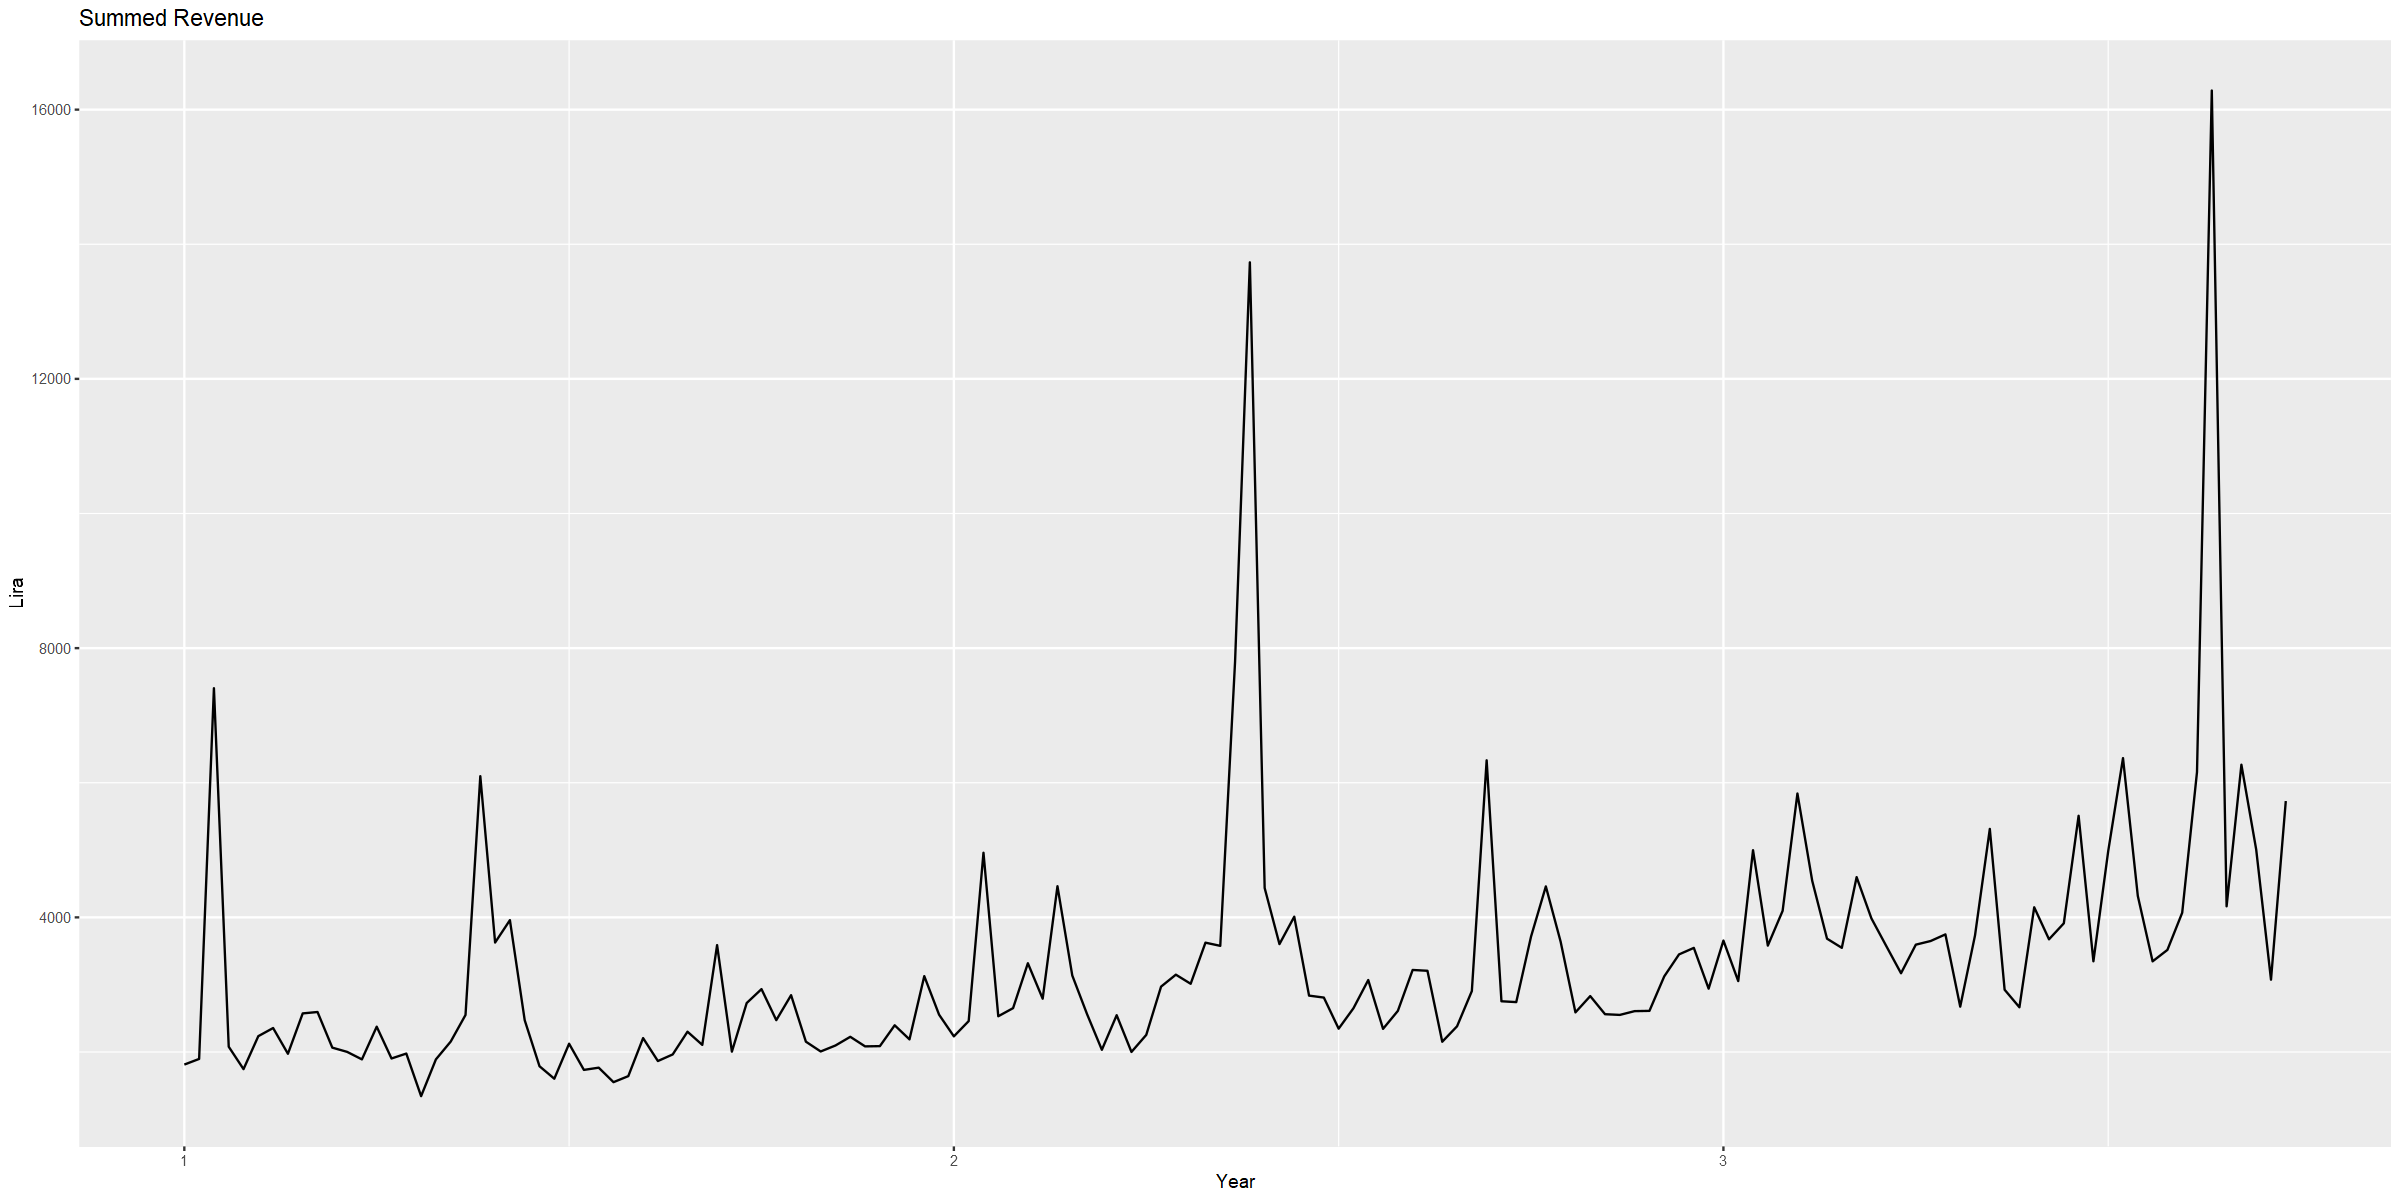

In [16]:
options(repr.plot.width = 20, repr.plot.height = 10)
autoplot(ts_real[[1]][, "summed_revenue"]) +
  ggtitle("Summed Revenue") +
  xlab("Year") +
  ylab("Lira")

### Seasonal plots

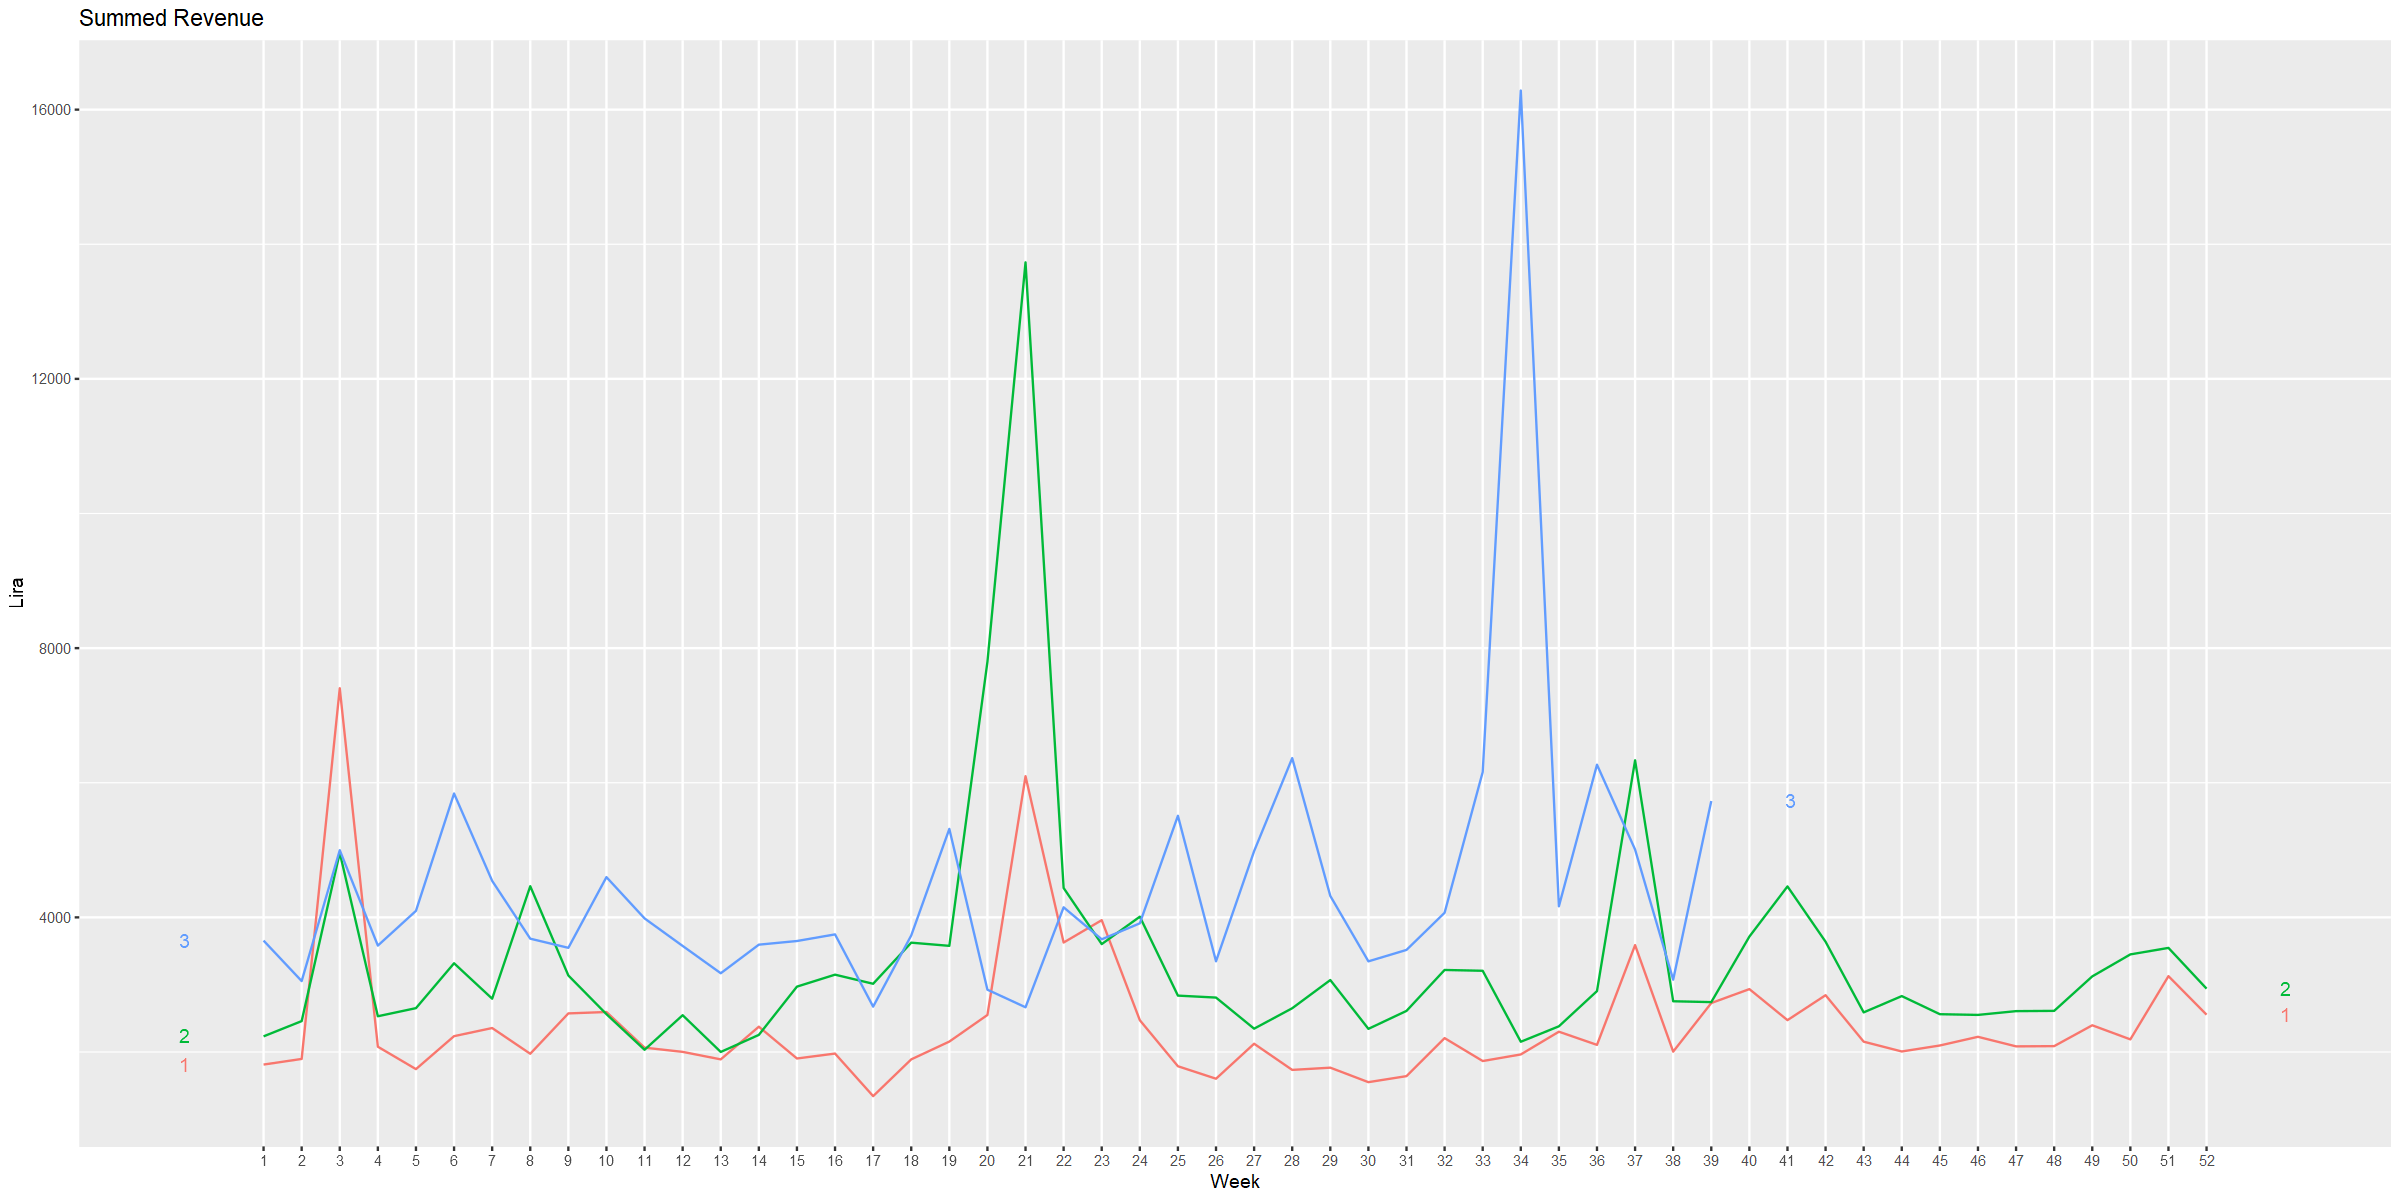

In [17]:
ggseasonplot(ts_real[[1]][, "summed_revenue"], year.labels=TRUE, year.labels.left=TRUE) +
  ylab("Lira") +
  ggtitle("Summed Revenue")

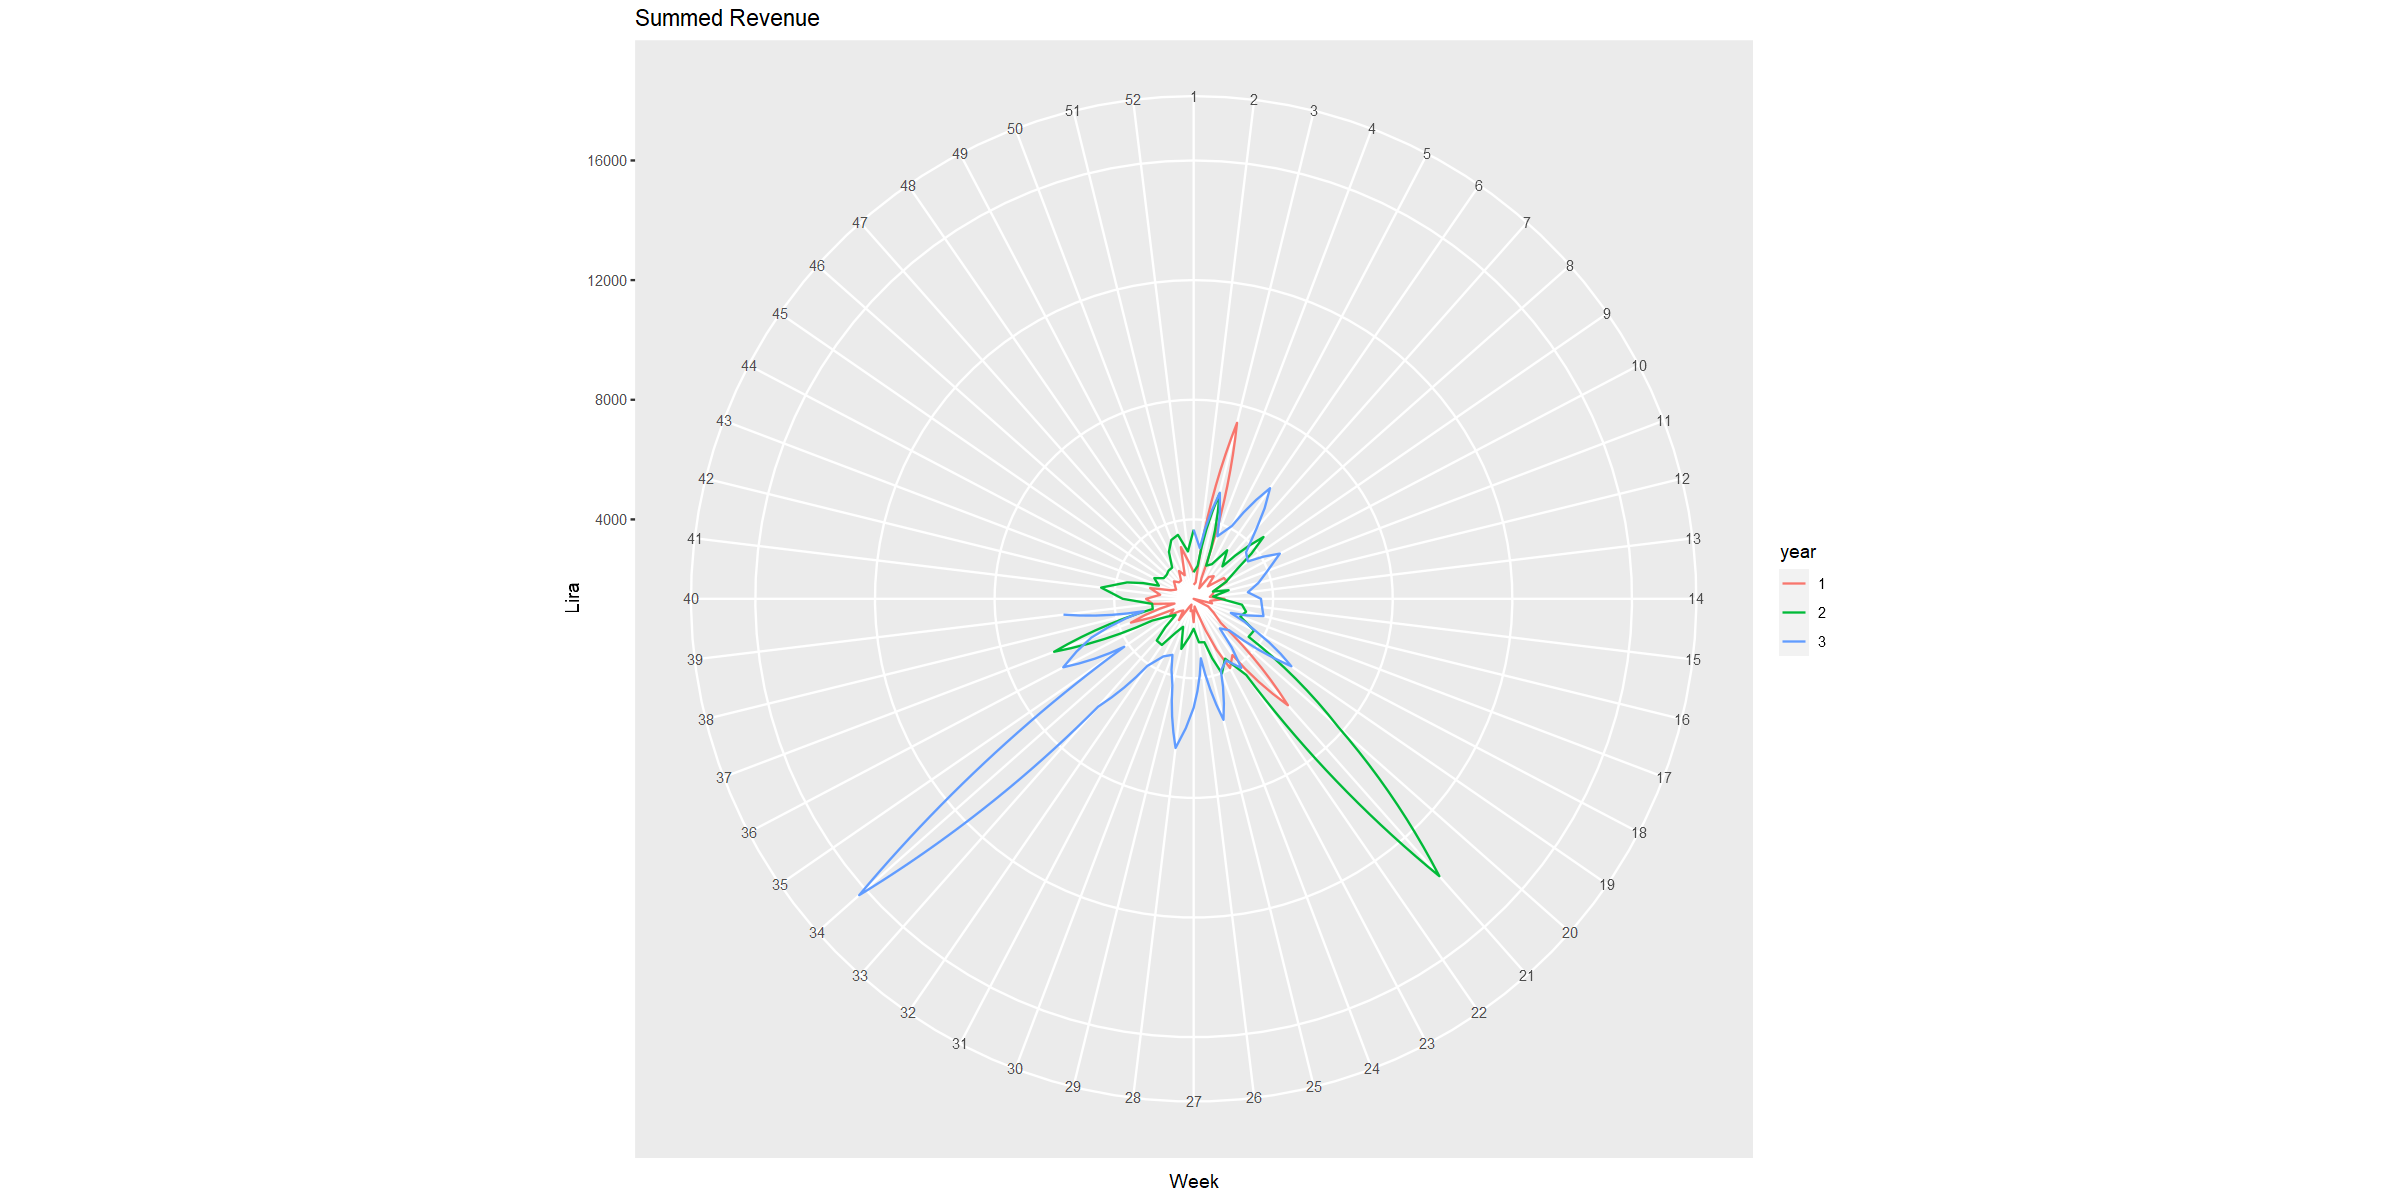

In [18]:
ggseasonplot(ts_real[[1]][, "summed_revenue"], polar=TRUE) +
  ylab("Lira") +
  ggtitle("Summed Revenue")

### Seasonal subseries plots

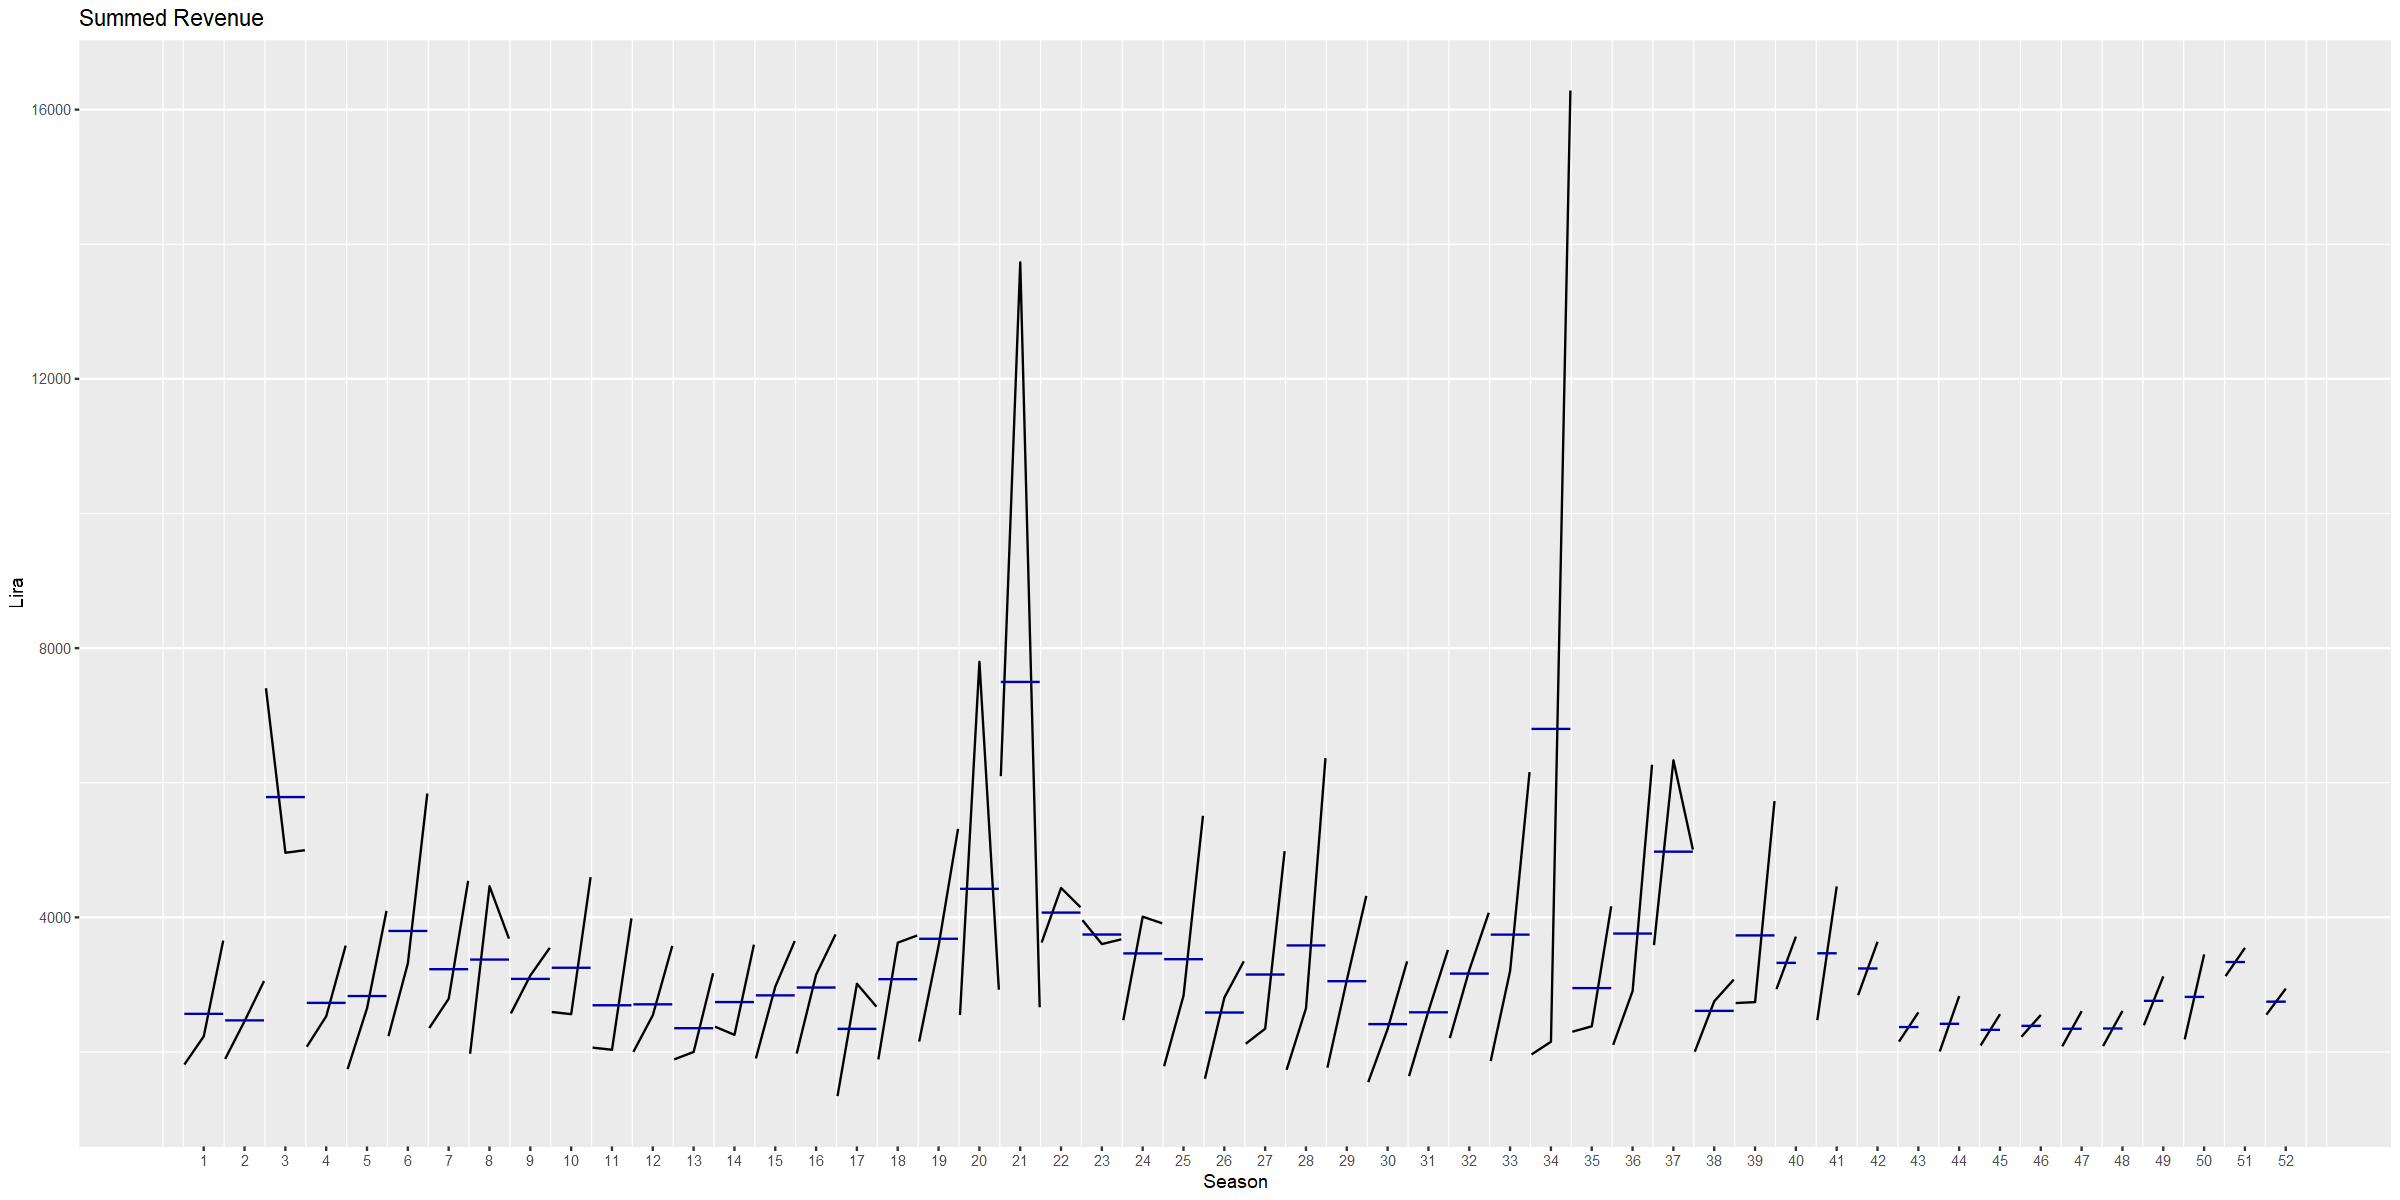

In [19]:
ggsubseriesplot(ts_real[[1]][, "summed_revenue"]) +
  ylab("Lira") +
  ggtitle("Summed Revenue")

## Decompose

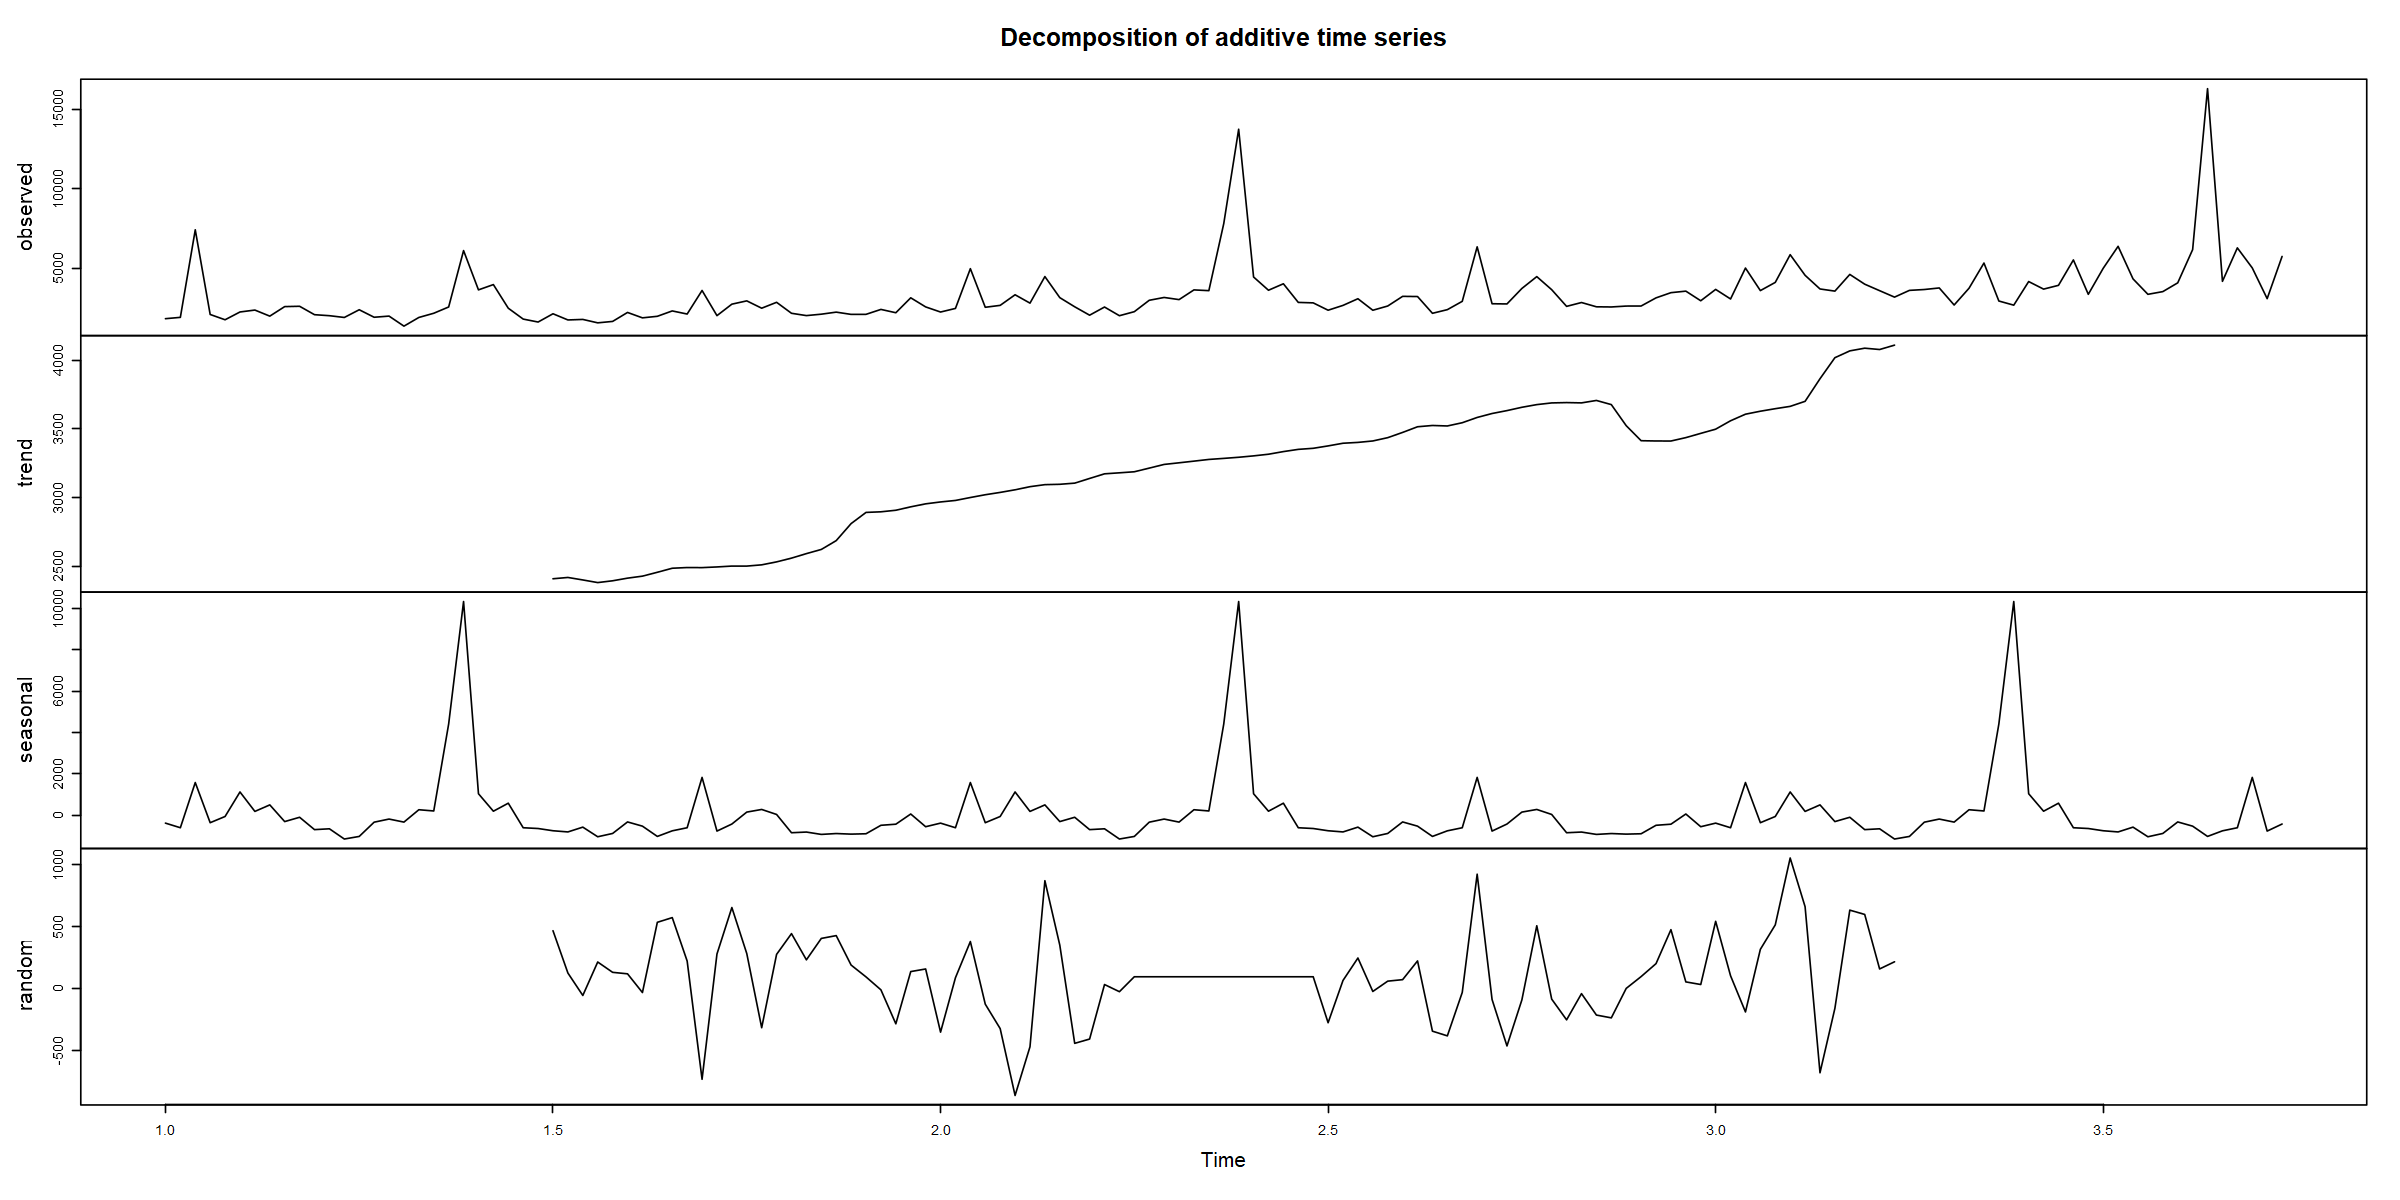

In [20]:
# Decompor uma série temporal
decomposed <- decompose(ts_real[[1]][, "summed_revenue"])
# Plotar os componentes
plot(decomposed)

###  Scatterplots Summed Revenue and Average Temperature

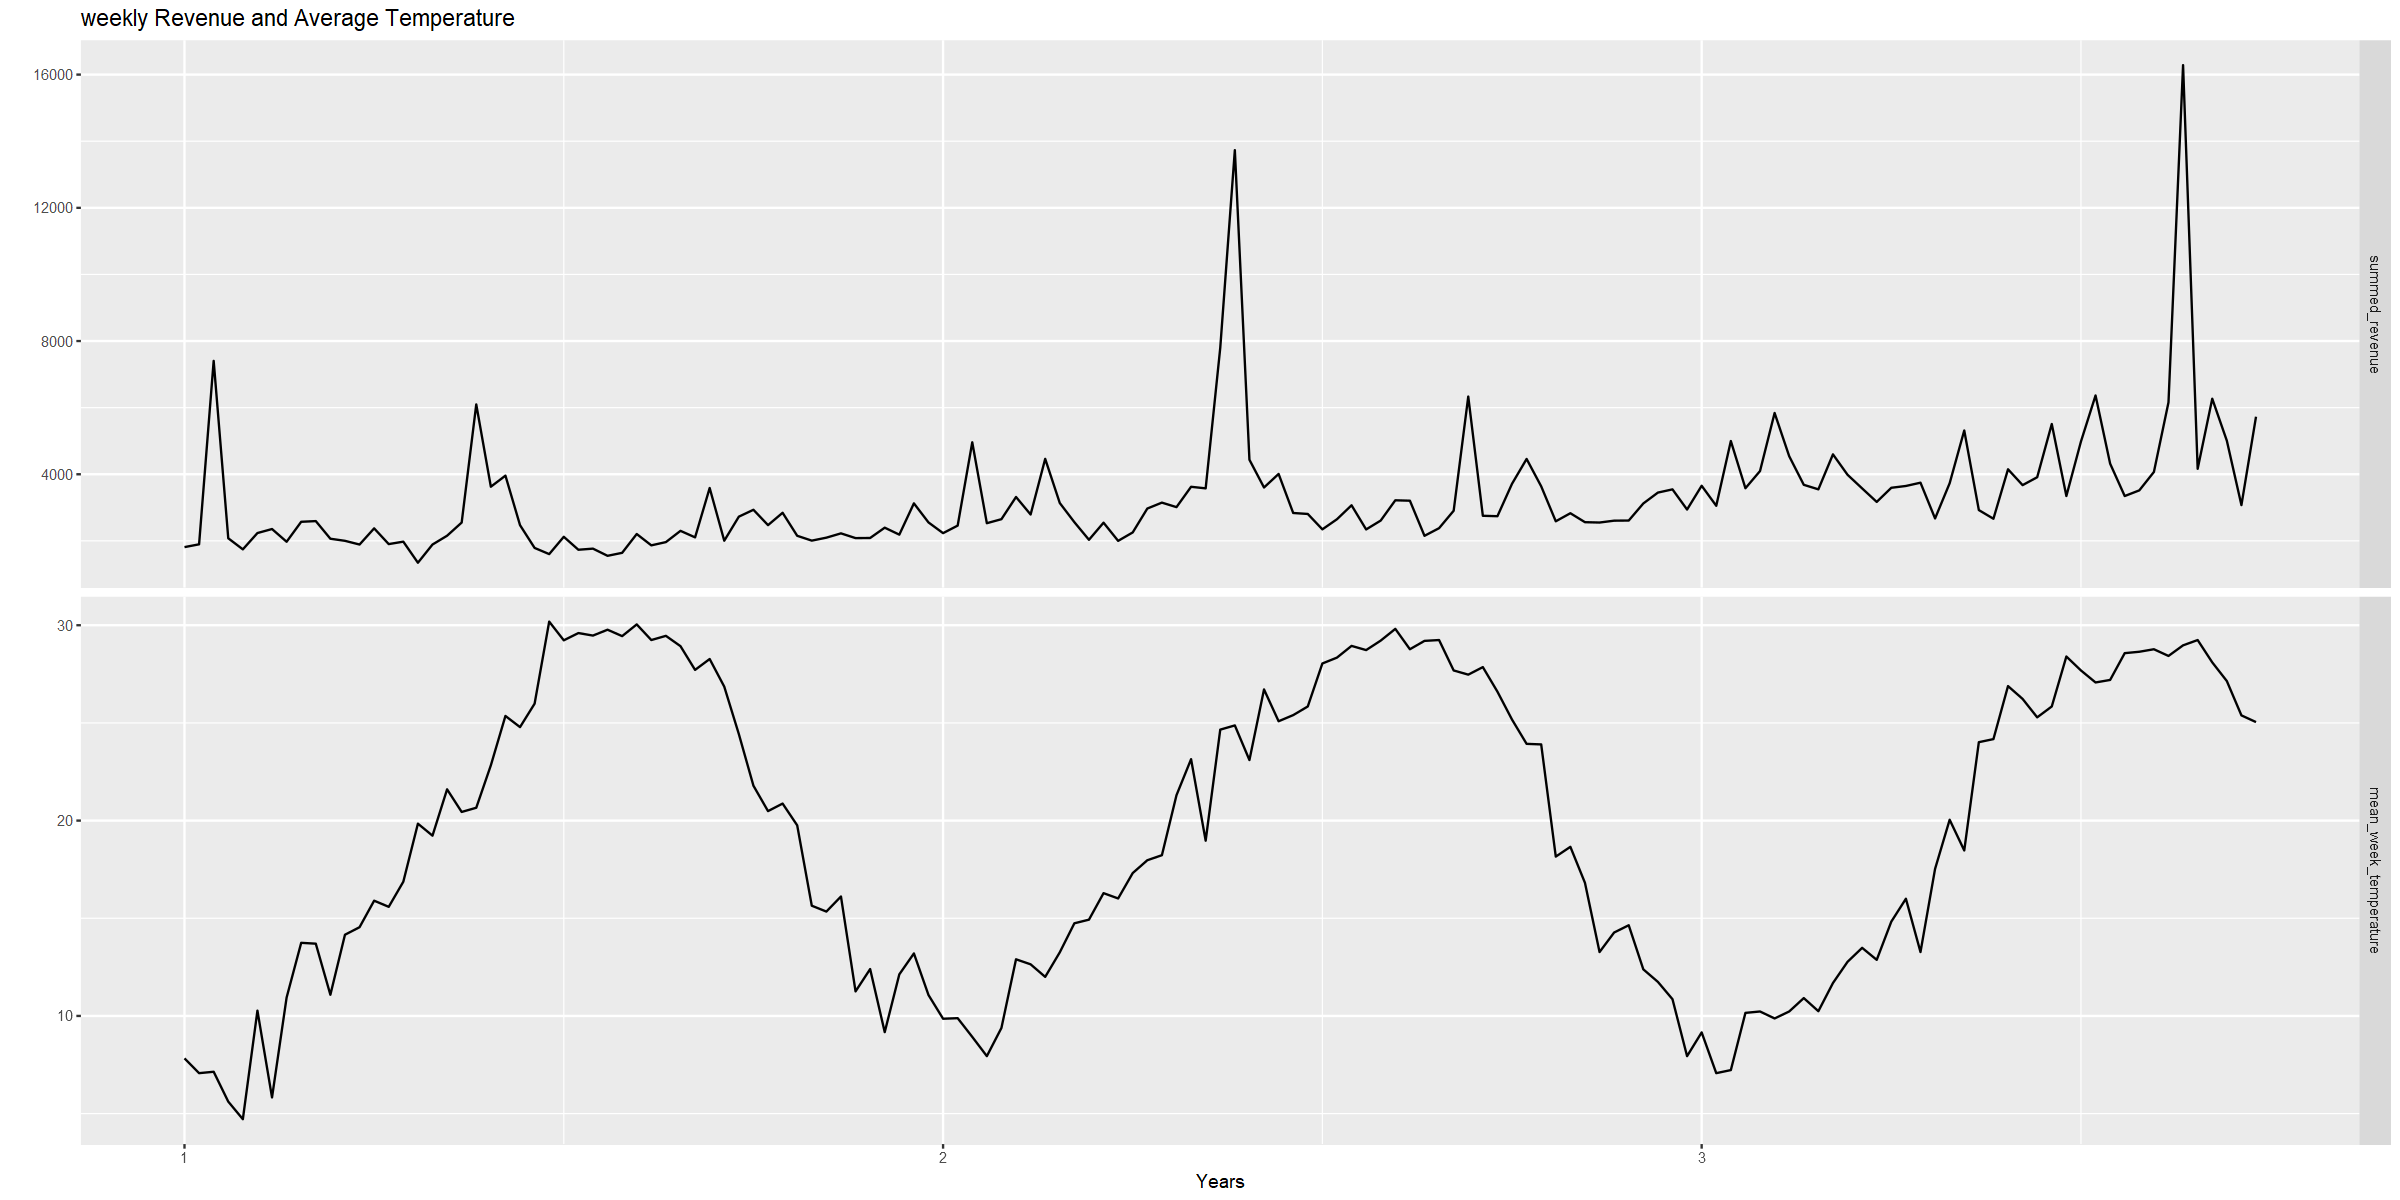

In [21]:
autoplot(ts_real[[1]][,c("summed_revenue","mean_week_temperature")], facets=TRUE) +
  xlab("Years") + ylab("") +
  ggtitle("weekly Revenue and Average Temperature")

###  Scatterplots Summed Revenue and weeks with holidays

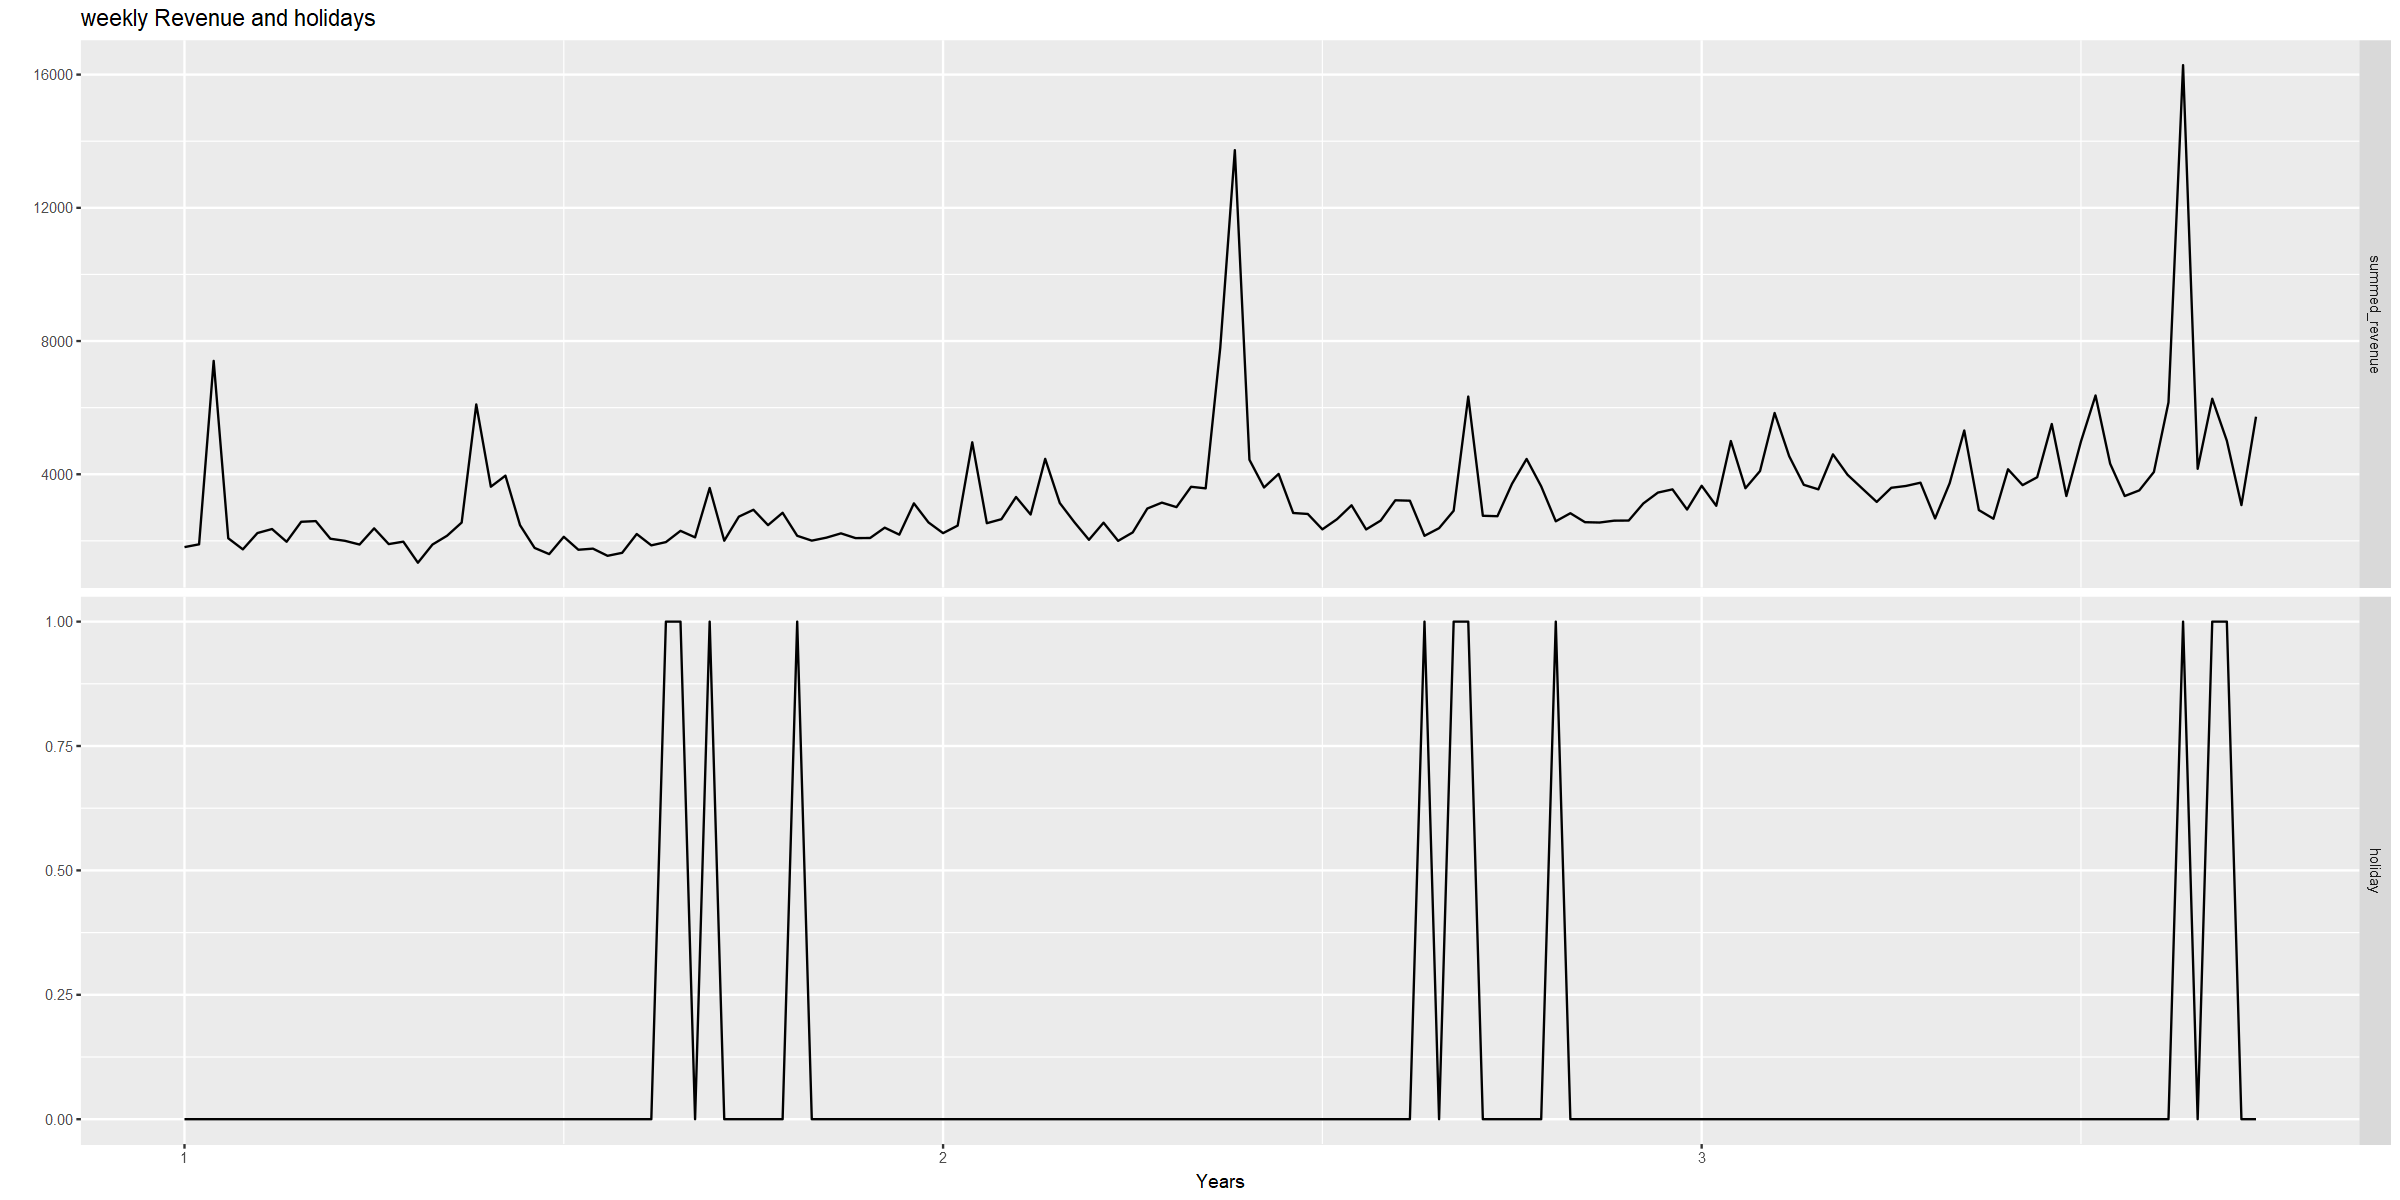

In [22]:
autoplot(ts_real[[1]][,c("summed_revenue","holiday")], facets=TRUE) +
  xlab("Years") + ylab("") +
  ggtitle("weekly Revenue and holidays")

###  Scatterplots Summed Revenue VS number_month & number_week

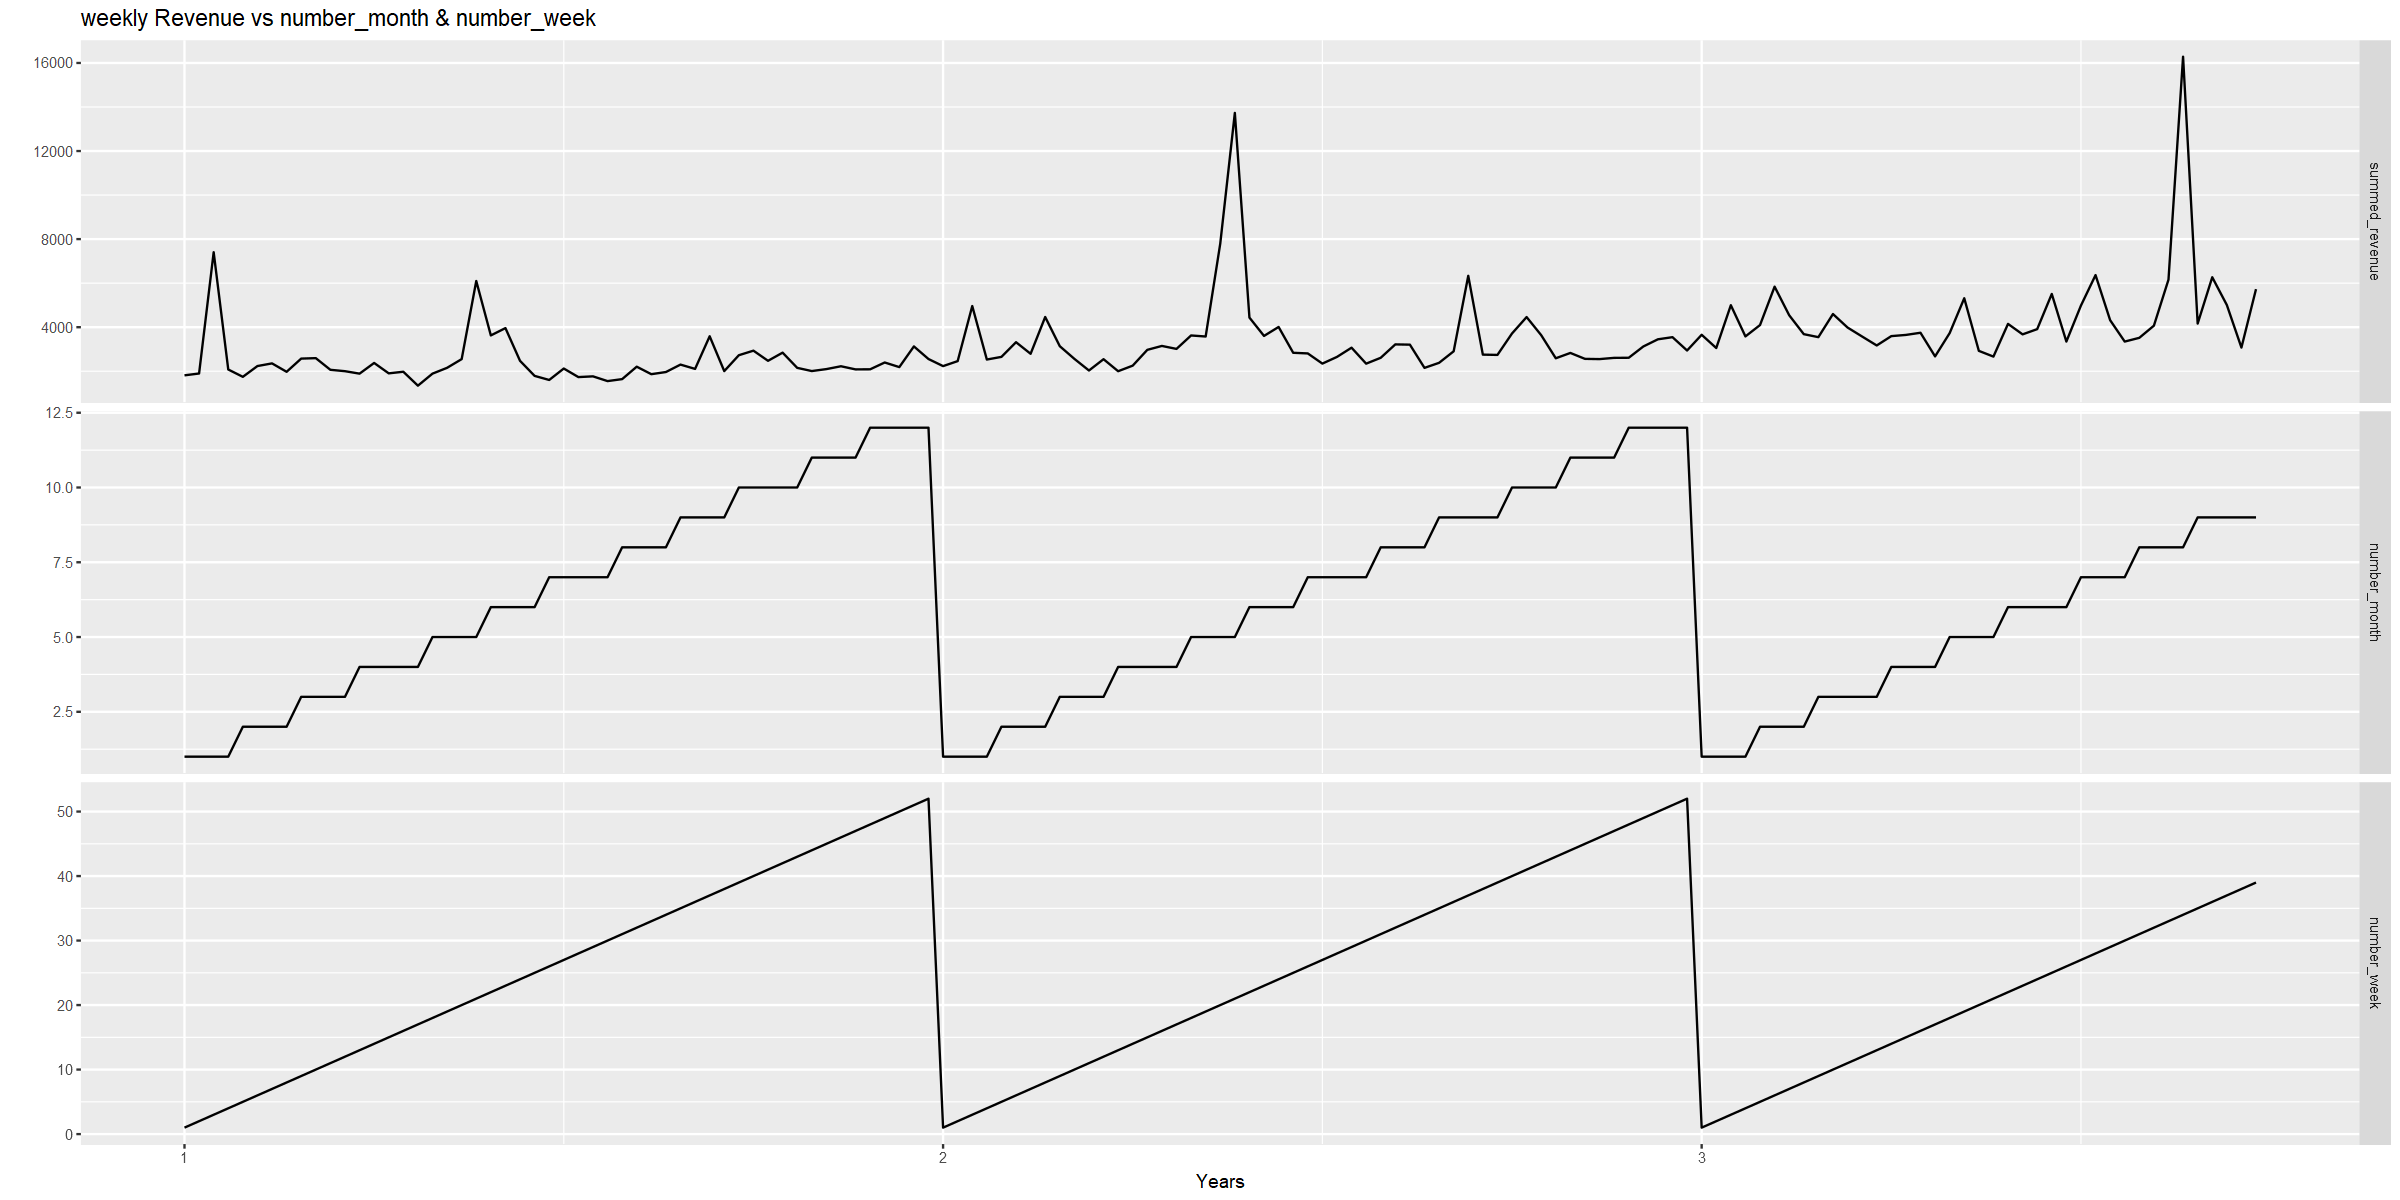

In [23]:
autoplot(ts_real[[1]][,c("summed_revenue","number_month","number_week")], facets=TRUE) +
  xlab("Years") + ylab("") +
  ggtitle("weekly Revenue vs number_month & number_week")

###  Scatterplots Summed Revenue VS seasons

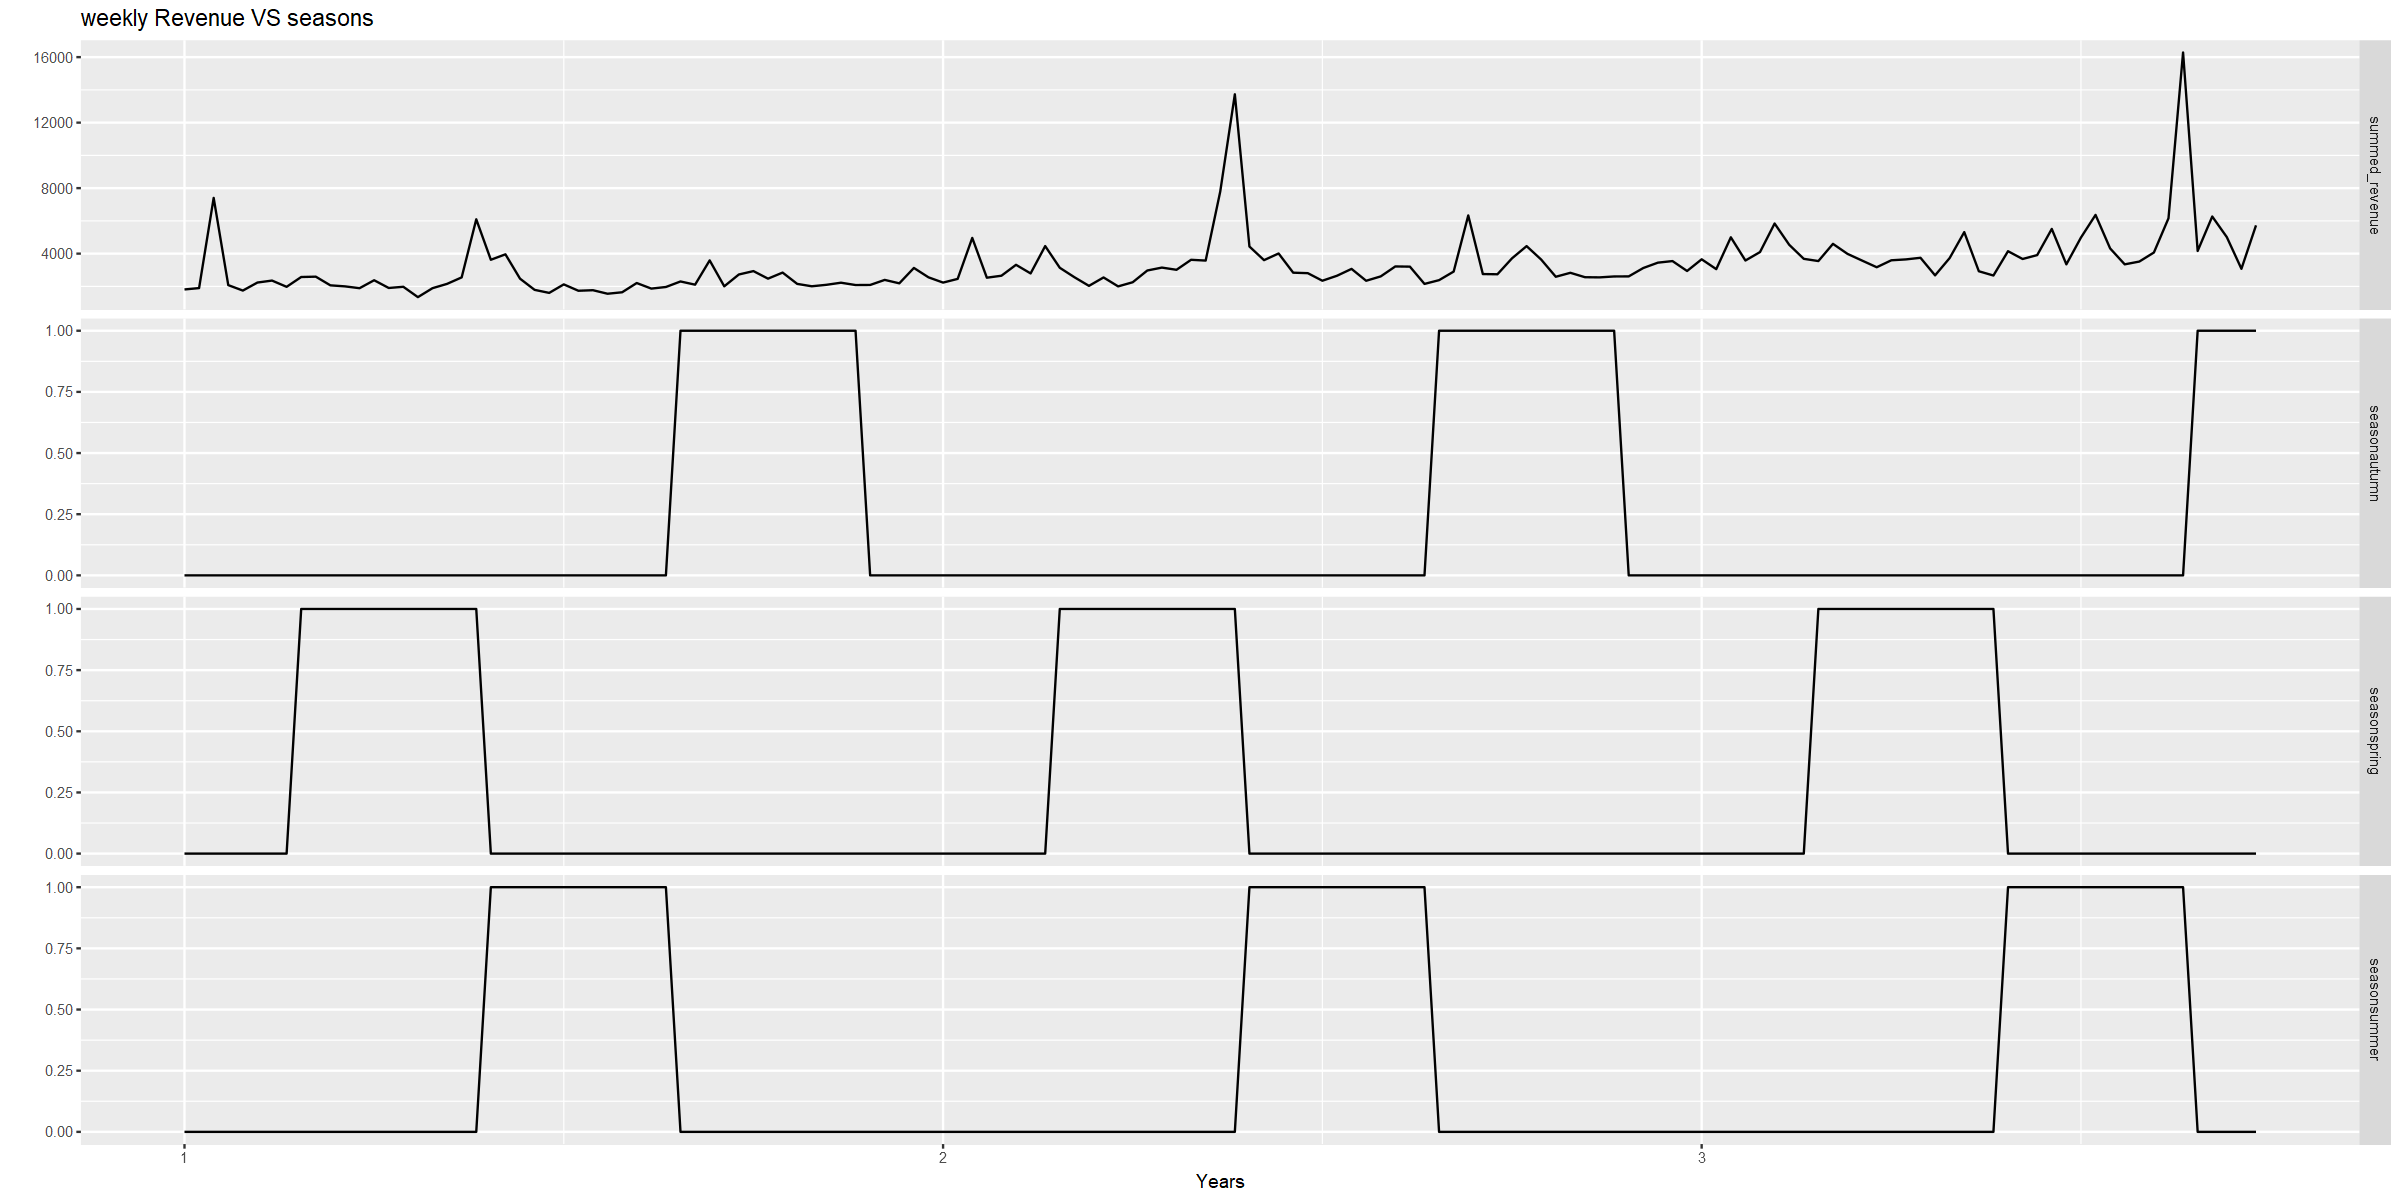

In [24]:
autoplot(ts_real[[1]][,c("summed_revenue","seasonautumn","seasonspring", "seasonsummer")], facets=TRUE) +
  xlab("Years") + ylab("") +
  ggtitle("weekly Revenue VS seasons")

### Correlation
#### Scatterplot matrices

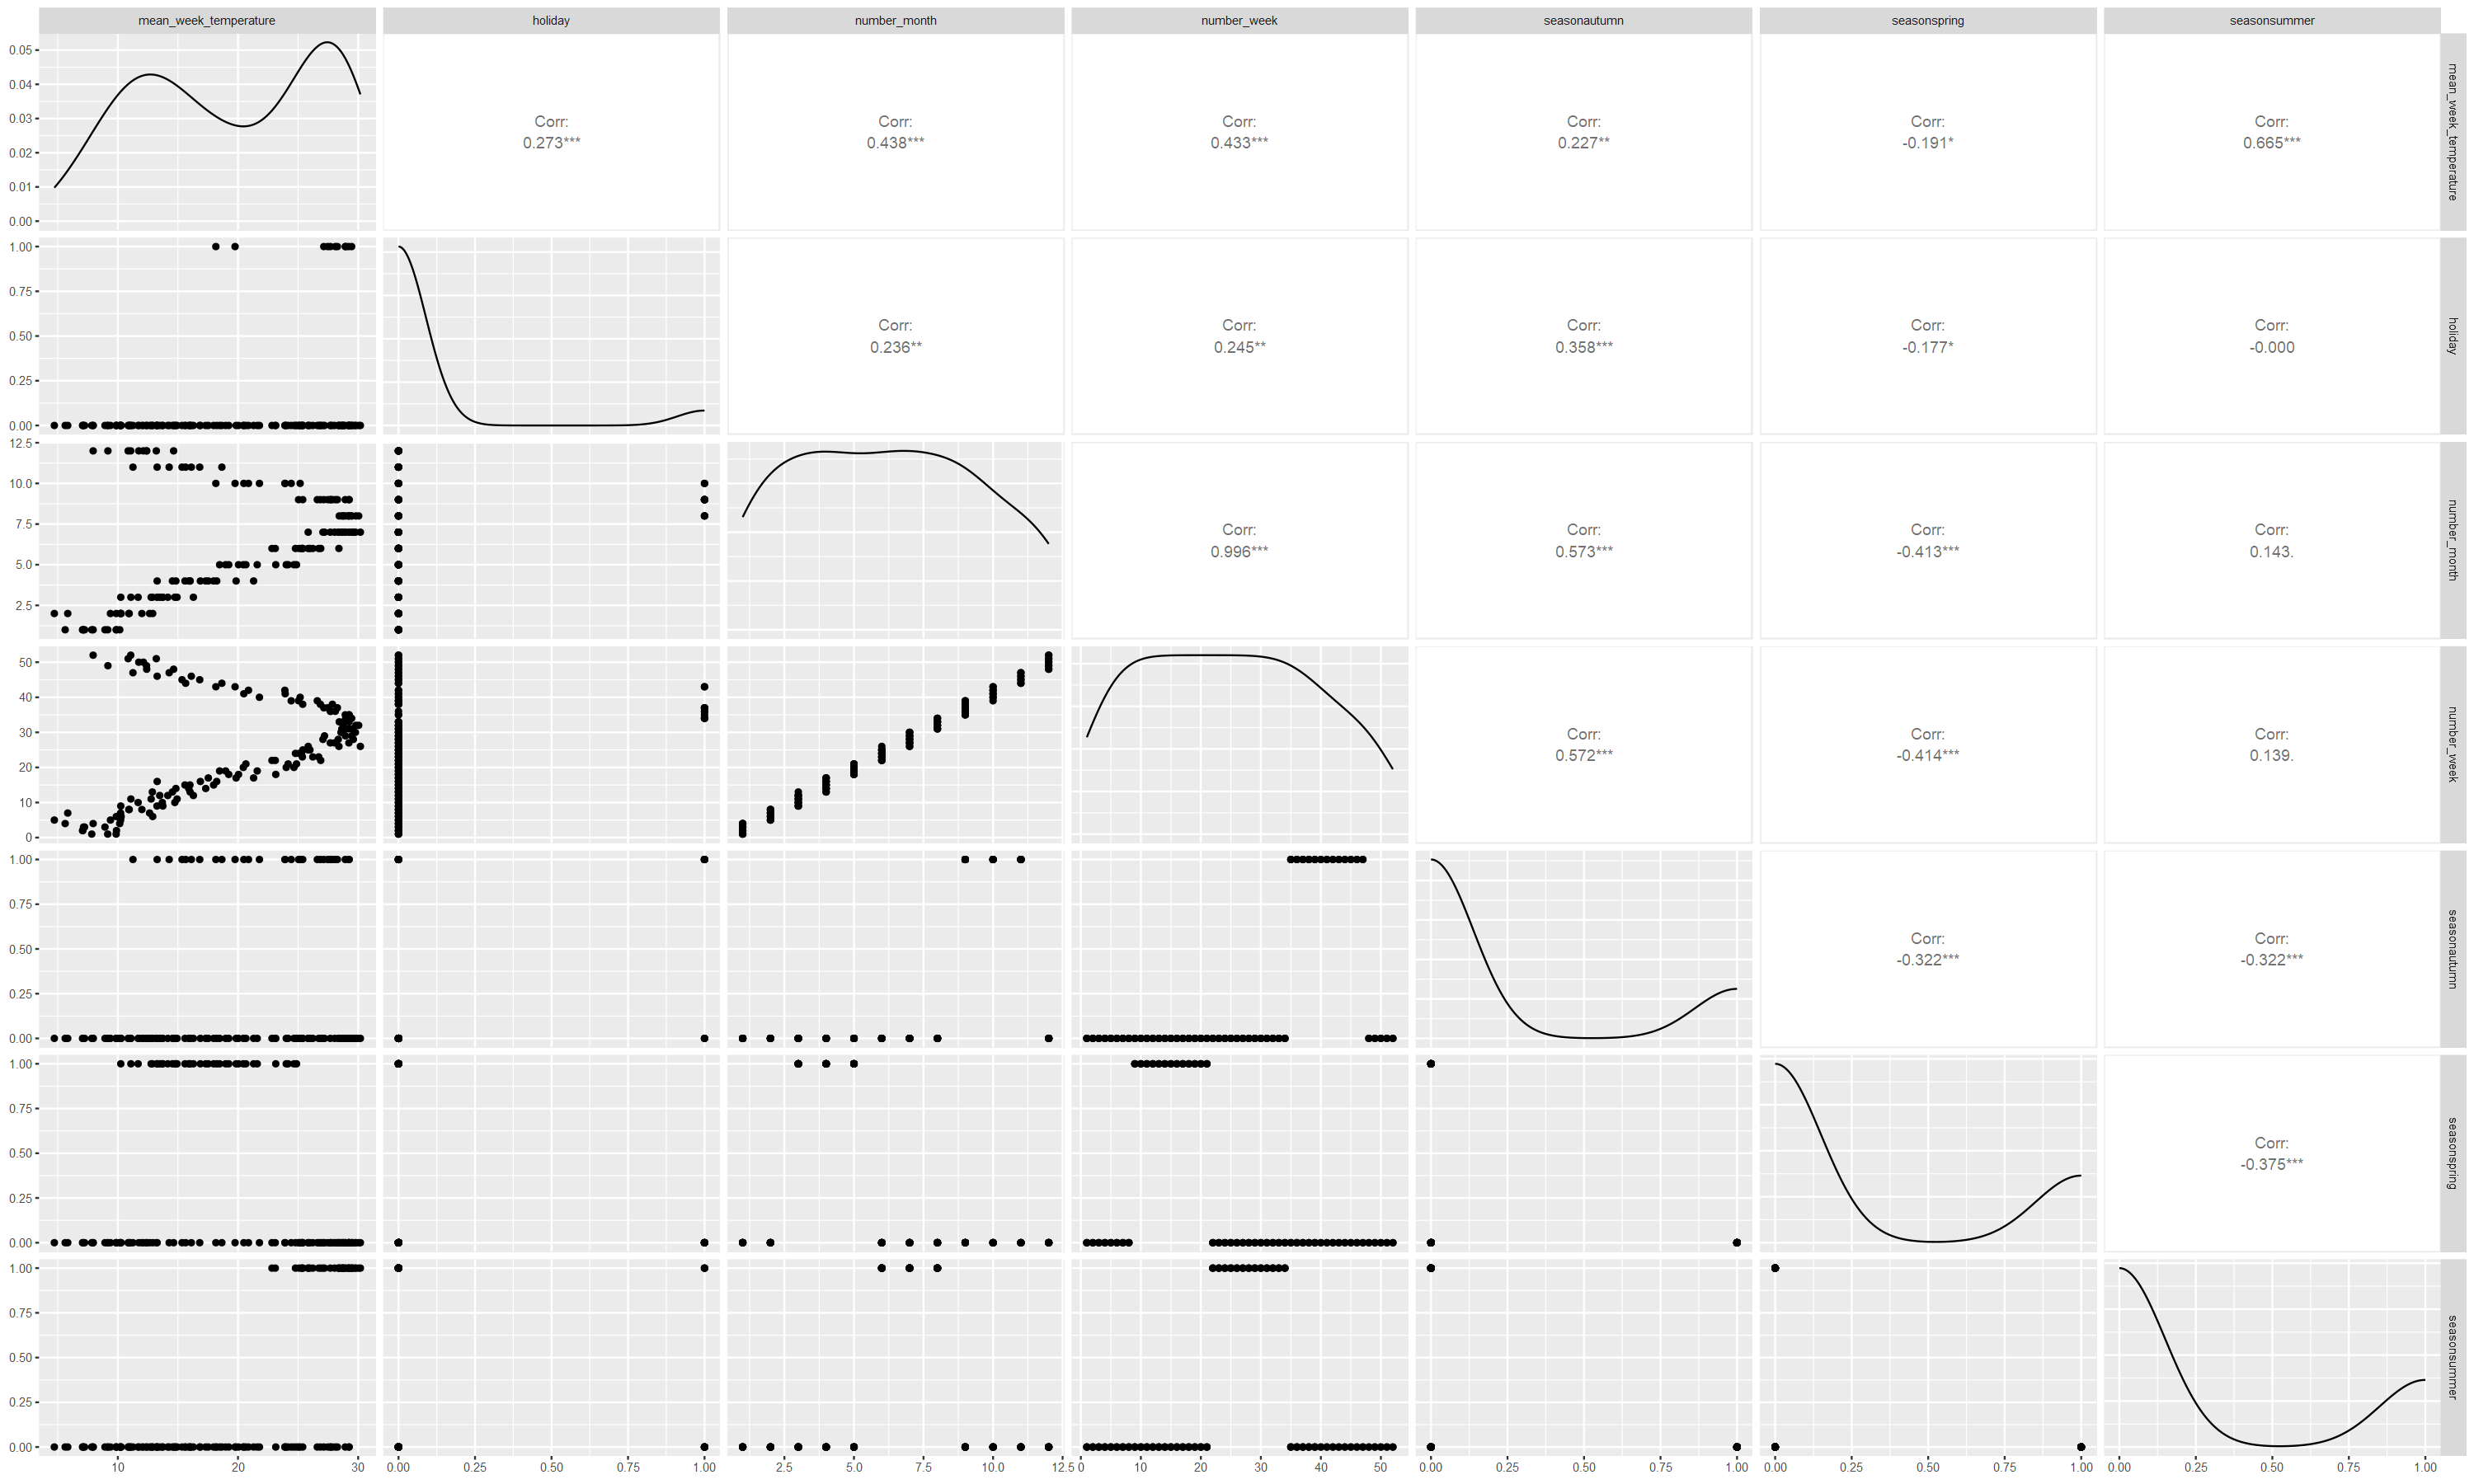

In [25]:
options(repr.plot.width = 25, repr.plot.height = 15)
subset_data <- ts_real[[1]][, 2:8]
ggpairs(as.data.frame(subset_data))

### Lag plots

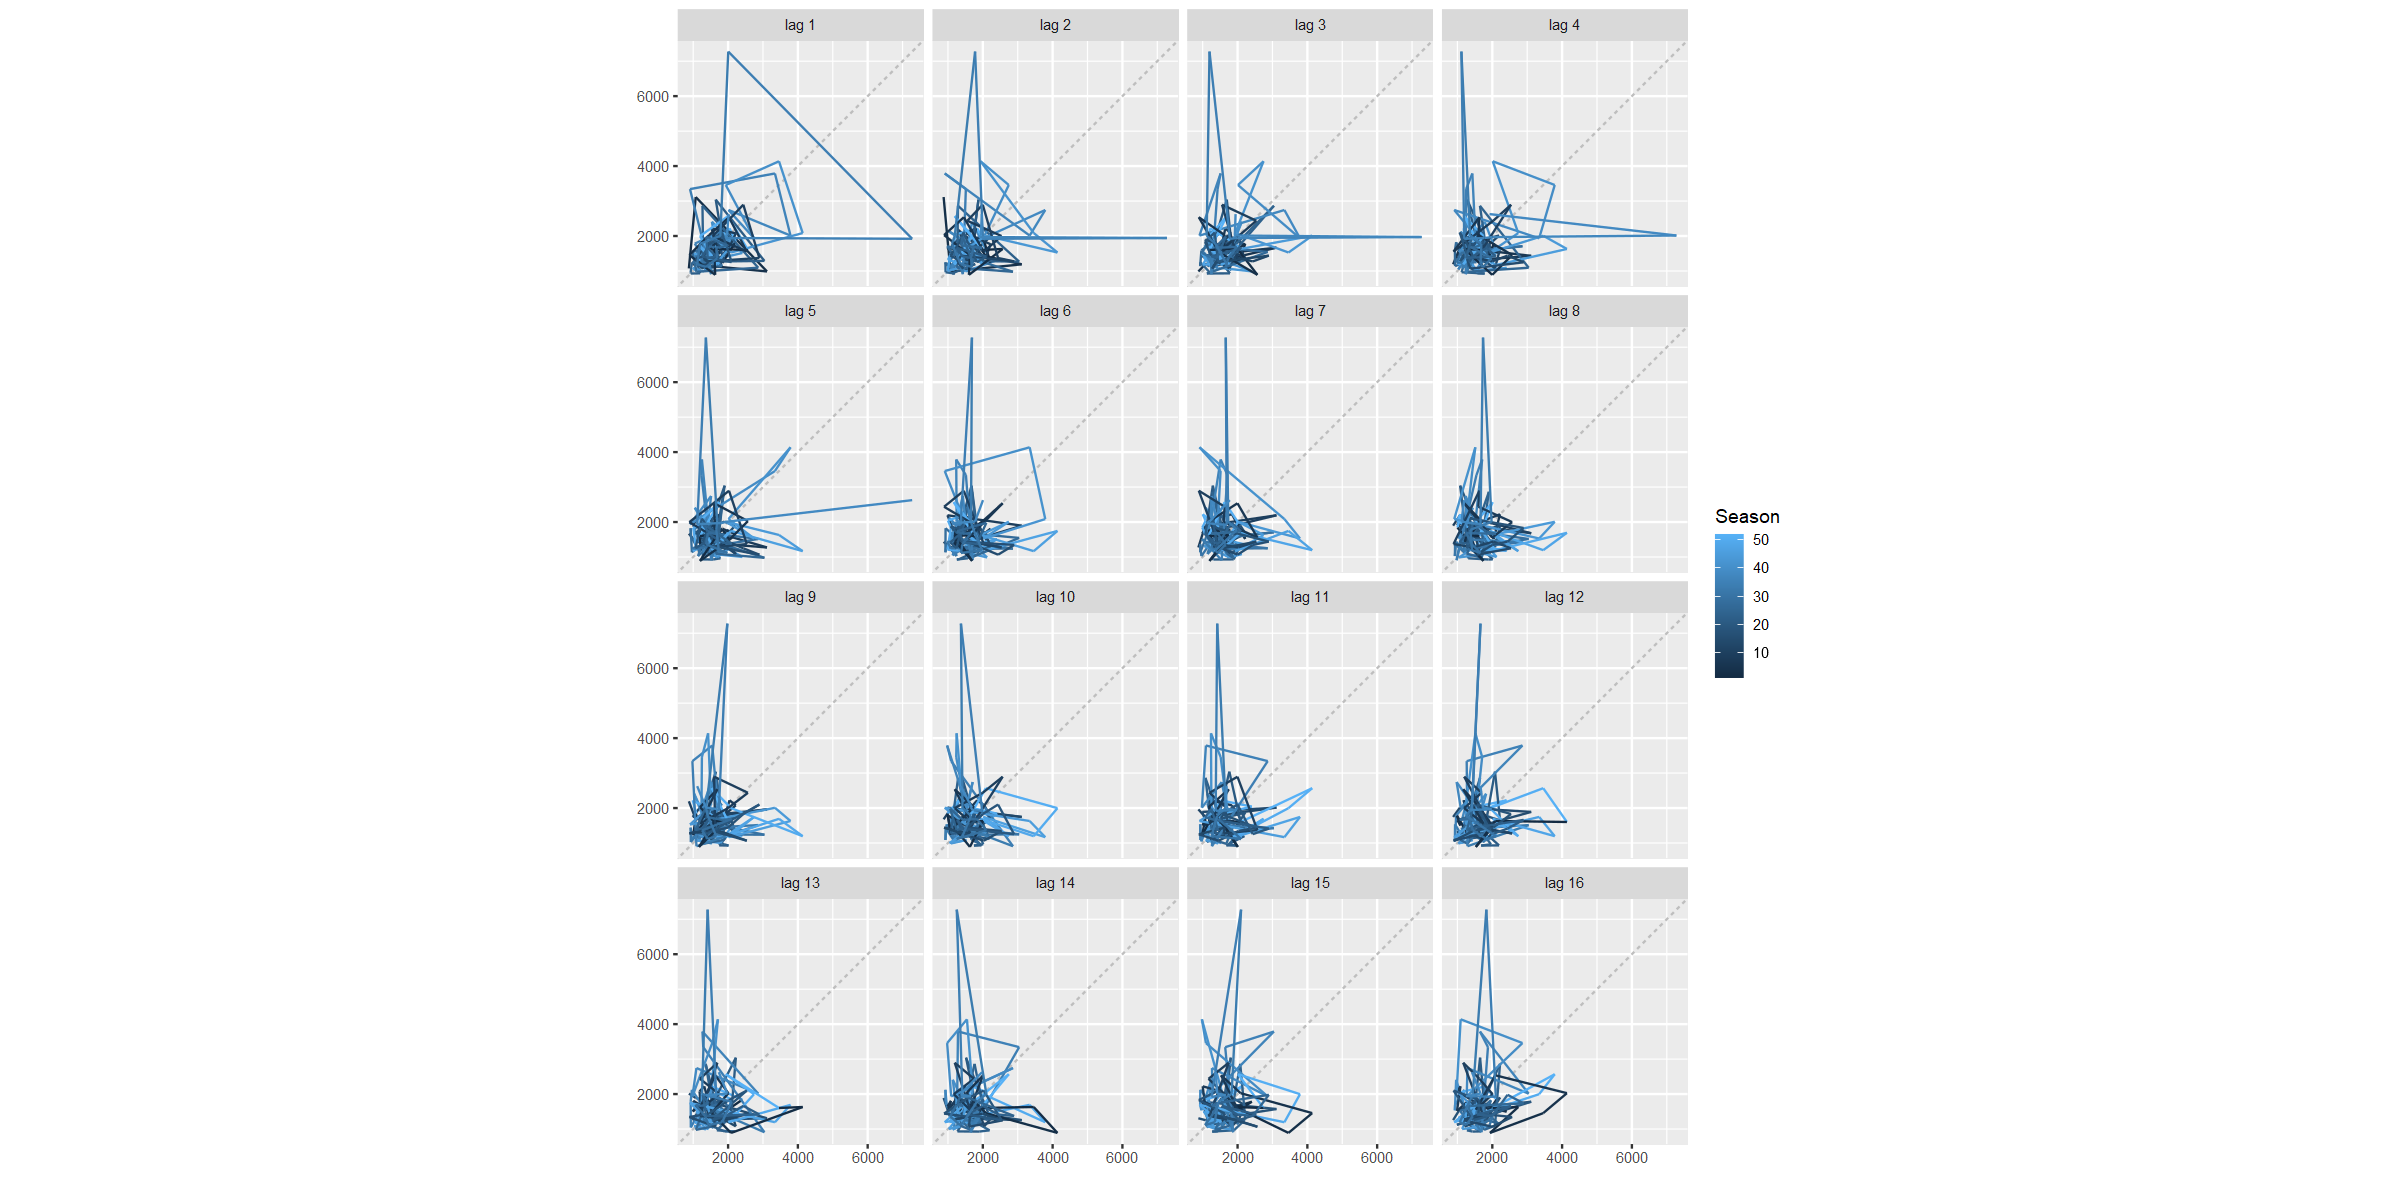

In [26]:
options(repr.plot.width = 20, repr.plot.height = 10)
gglagplot(ts_real[[50]][, "summed_revenue"])

## Autocorrelation

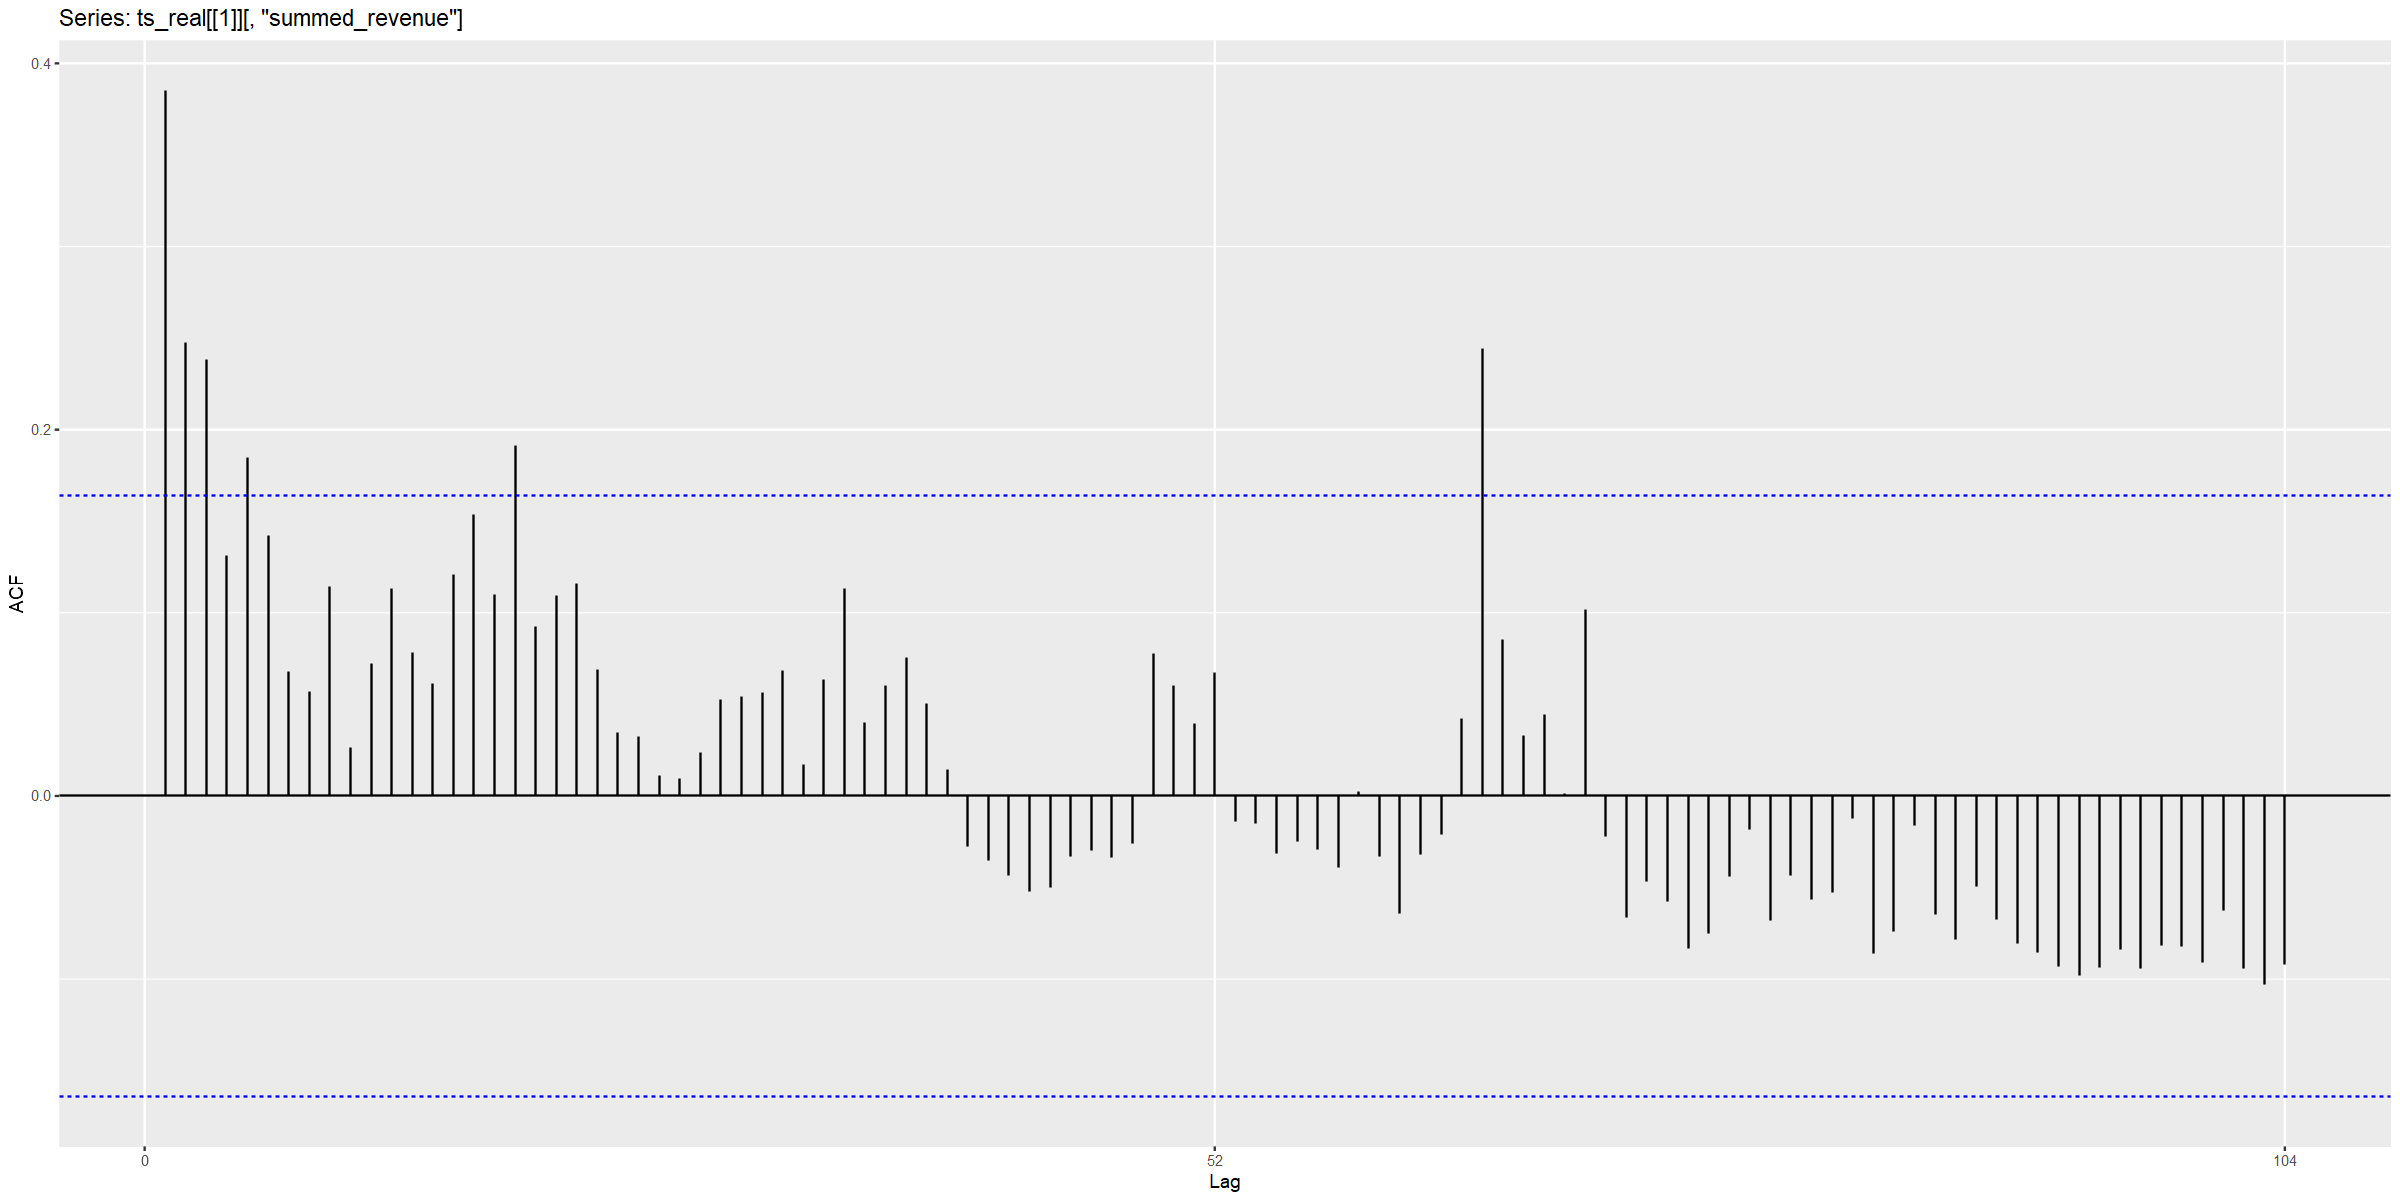

In [27]:
ggAcf(ts_real[[1]][, "summed_revenue"])

In [28]:
# Calcula a matriz de correlação
matriz_correlacao <- cor(ts_real[[1]][, -1])
# Exibe a matriz de correlação
matriz_correlacao

,mean_week_temperature,holiday,number_month,number_week,seasonautumn,seasonspring,seasonsummer
mean_week_temperature,1.0000000,2.730578e-01,0.4377359,0.4328131,0.2267513,-0.1907247,6.648997e-01
holiday,0.2730578,1.000000e+00,0.2362960,0.2445712,0.3576369,-0.1767767,-1.477392e-20
number_month,0.4377359,2.362960e-01,1.0000000,0.9961640,0.5734387,-0.4127511,1.429086e-01
number_week,0.4328131,2.445712e-01,0.9961640,1.0000000,0.5718037,-0.4142767,1.393828e-01
seasonautumn,0.2267513,3.576369e-01,0.5734387,0.5718037,1.0000000,-0.3221718,-3.221718e-01
seasonspring,-0.1907247,-1.767767e-01,-0.4127511,-0.4142767,-0.3221718,1.0000000,-3.750000e-01
seasonsummer,0.6648997,-1.477392e-20,0.1429086,0.1393828,-0.3221718,-0.3750000,1.000000e+00


In [29]:
# Calcula a matriz de covariância
matriz_covariancia <- cov(ts_real[[1]][, -1])
# Exibe a matriz de covariância
matriz_covariancia

,mean_week_temperature,holiday,number_month,number_week,seasonautumn,seasonspring,seasonsummer
mean_week_temperature,57.6114930,5.542176e-01,11.0234751,47.4018200,0.71167565,-0.64699104,2.255524e+00
holiday,0.5542176,7.150596e-02,0.2096425,0.9436620,0.03954496,-0.02112676,-1.765646e-21
number_month,11.0234751,2.096425e-01,11.0078794,47.6895006,0.78671329,-0.61203585,2.119078e-01
number_week,47.4018200,9.436620e-01,47.6895006,208.1997439,3.41165173,-2.67157490,8.988476e-01
seasonautumn,0.7116756,3.954496e-02,0.7867133,3.4116517,0.17098395,-0.05953905,-5.953905e-02
seasonspring,-0.6469910,-2.112676e-02,-0.6120359,-2.6715749,-0.05953905,0.19974392,-7.490397e-02
seasonsummer,2.2555241,-1.765646e-21,0.2119078,0.8988476,-0.05953905,-0.07490397,1.997439e-01


## Dimensionality-reduction method PCA

In [30]:
# PCA para redução de dimensionalidade e seleção das principais variáveis
pca_real_ts <- list()
pca_train_ts <- list()
pca_test_ts <- list()
for (t in names(ts_real)){
    data <- ts_real[[t]]
    # criar PCA
    pca <- prcomp(data[,-1], scale. = TRUE)
    # Variance
    pca.var <- pca$sdev ^ 2
    # Proportion of Variance
    pca.pvar <- pca.var / sum(pca.var)
    # Reduce the number of features while explaining x variability 75%
    n.components <- which(cumsum(pca.pvar) >= 0.75)[1]
    data_pca <- as.data.frame(pca$x[,1:n.components])
    #addicionar target
    data_pca$summed_revenue <- data[,1]
    train_pca <- head(data_pca, -5)
    test_pca <- tail(data_pca, 5)
    # transformar em ts
    ts <- ts(data = data_pca, frequency = 52)
    pca_real_ts[[t]] <- ts
    ts <- ts(data = train_pca, frequency = 52)
    pca_train_ts[[t]] <- ts
    ts <- ts(data = test_pca, frequency = 52)
    pca_test_ts[[t]] <- ts
}
length(pca_real_ts)
length(pca_train_ts)
length(pca_test_ts)

[1] 63

[1] 63

[1] 63

## Model

In [31]:
# armazena valores de previsões
forecast_values <- list() 
arima_xreg <- list() # armazena modelos
for (ts in names(pca_train_ts)) {
  if (!(ts %in% c("S0136"))) {
    tryCatch({
      data_train <- pca_train_ts[[ts]]
      data_test <- pca_test_ts[[ts]]
      # numero de colunas 
      num_col <- ncol(data_train)
      # Ajustar o modelo ARIMA com regressores externos
      model <- auto.arima(data_train[, num_col], xreg = data_train[, 1:num_col-1])
      arima_xreg[[ts]] <- model
      # Realizar previsões
      forecast <- forecast(model, xreg = data_test[, 1:num_col-1])
      forecast_values[[ts]] <- round(forecast$mean,2)
    }, error = function(e) {
      # Lidar com o erro e passar para a próxima iteração
      message(paste("Erro ocorrido para", ts, ": ", e$message))
      next
    })
  } else {
    #exeção loja S0136
      data <-df_list[[ts]]
      # Acrescentar variavel open_closed
      data$open_closed <- ifelse(data$number_month %in% c(1, 2, 3, 4, 9, 10, 11, 12), 0, 1)
      ts_data <- as.matrix(data[, !(names(data) %in% c('store_id', 'date'))])
      ts_data_train <- head(data, -5)
      ts_data_test <-  tail(data, 5)
      exogenous_var <- ts_data_train[, "open_closed"]
      model <- auto.arima(ts_data_train[,"summed_revenue"], xreg = exogenous_var)
      arima_xreg[[ts]] <- model
      # Realizar previsões
      exogenous_var <- ts_data_test[, "open_closed"]
      forecast <- forecast(model, xreg = exogenous_var , h = 5)
      forecast_values[[ts]] <- round(forecast$mean,2)
    }
}
length(forecast_values)
length(arima_xreg)

[1] 63

[1] 63

In [32]:
# Ex : Loja 'S0041'
# Ver as informações do modelo
summary(arima_xreg[['S0041']])

Series: data_train[, num_col] 
Regression with ARIMA(0,1,1) errors 

Coefficients:
          ma1     PC1       PC2      PC3
      -0.8038  9.0858  -18.9400  -2.5087
s.e.   0.0663  4.8381    5.6937   5.7920

sigma^2 = 3382:  log likelihood = -749.54
AIC=1509.07   AICc=1509.53   BIC=1523.67

Training set error measures:
                    ME     RMSE      MAE       MPE     MAPE      MASE
Training set -2.333297 57.09447 44.85471 -6.183505 20.30294 0.5582447
                   ACF1
Training set 0.05390575

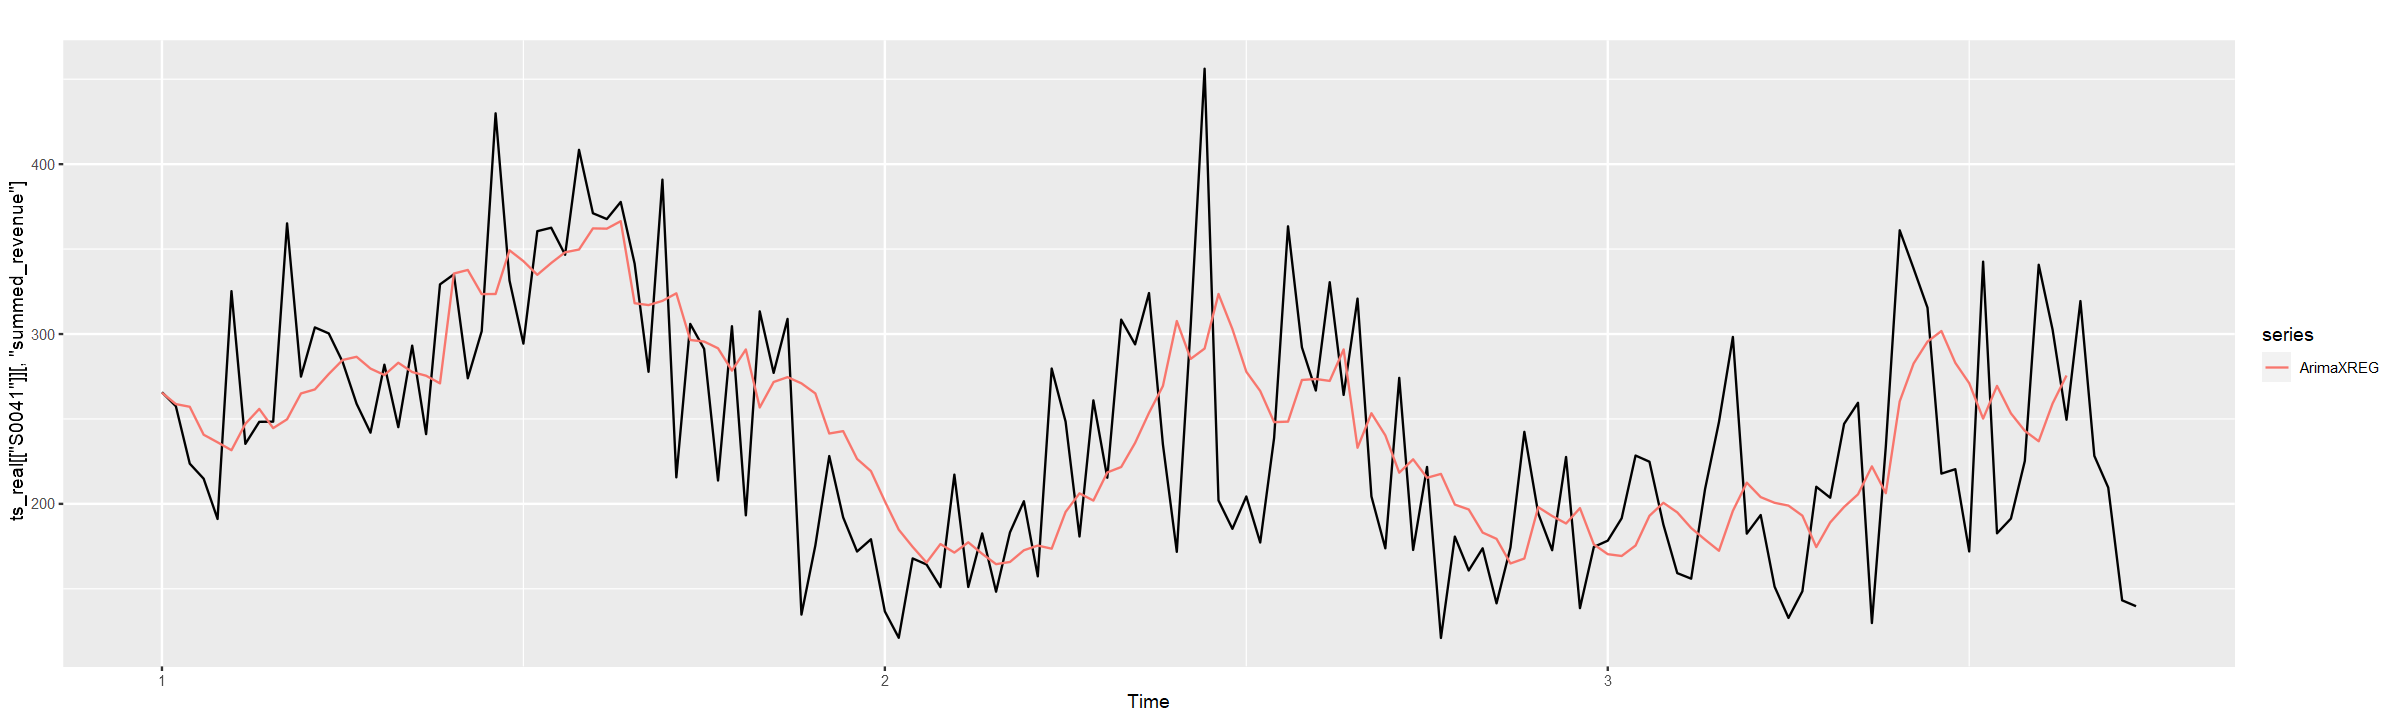

In [33]:
# Ver os valores reais VS valores ajustados pelo modelo
options(repr.plot.width = 20, repr.plot.height = 6)

autoplot(ts_real[['S0041']][,"summed_revenue"])+autolayer(arima_xreg[['S0041']]$fitted, series = "ArimaXREG")


	Ljung-Box test

data:  Residuals from Regression with ARIMA(0,1,1) errors
Q* = 20.194, df = 27, p-value = 0.8225

Model df: 1.   Total lags used: 28



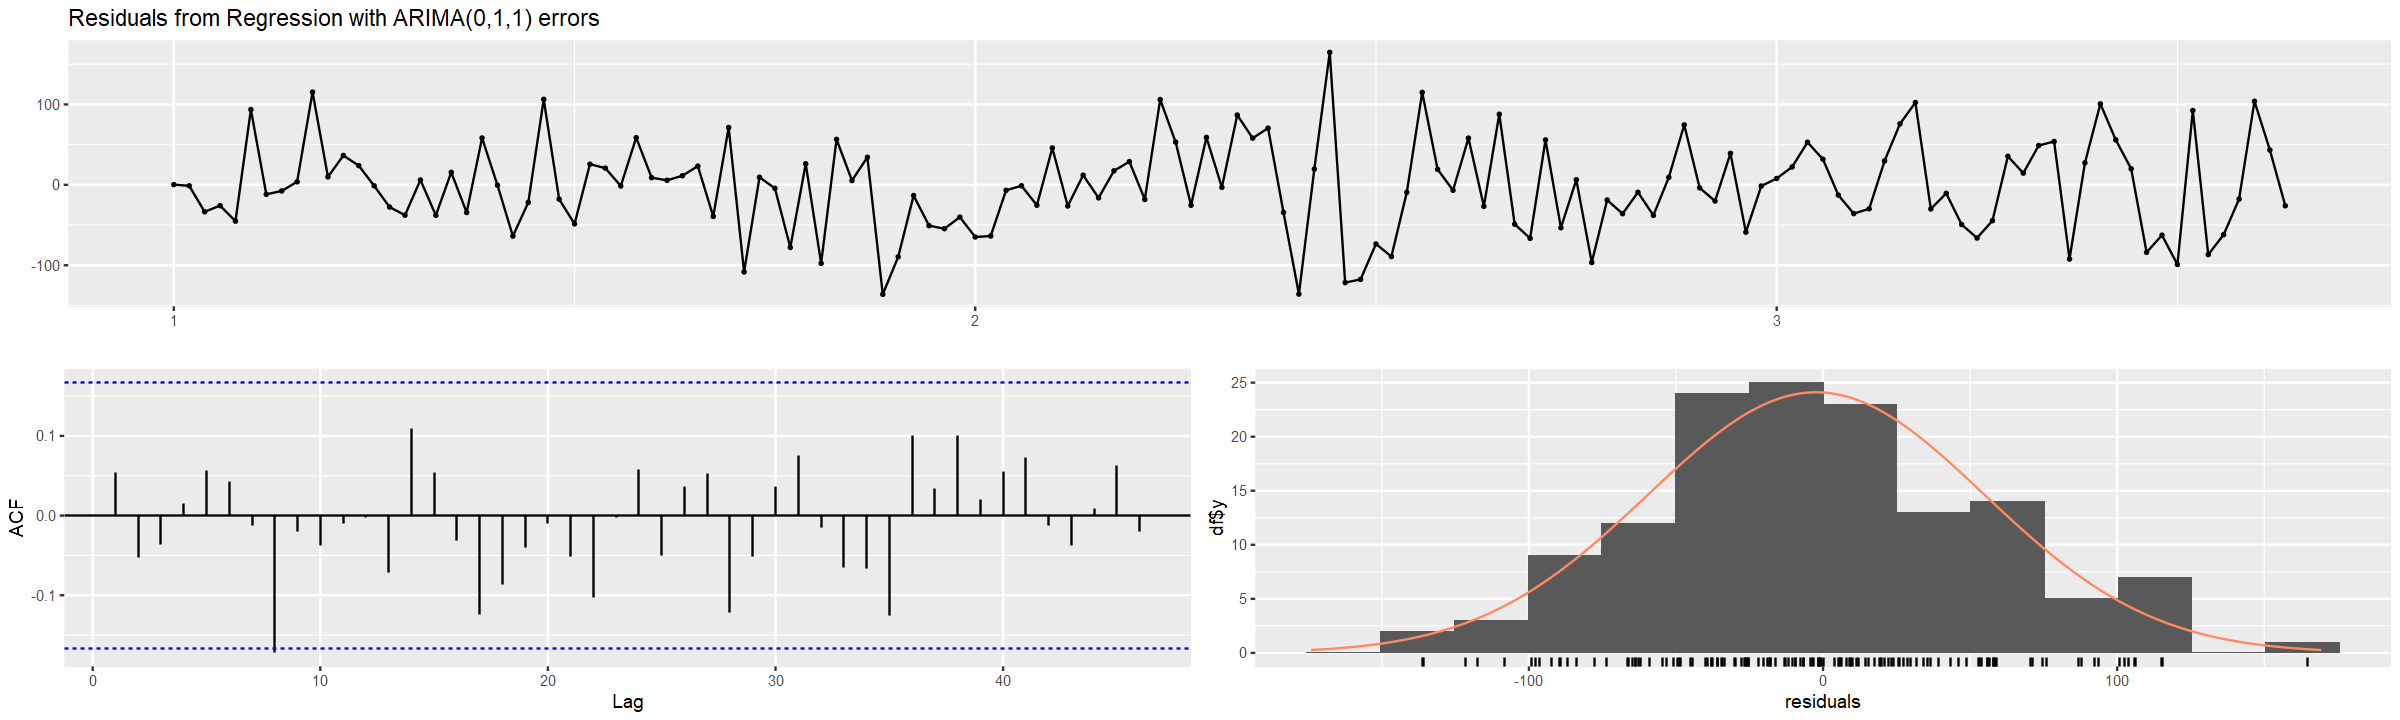

In [34]:
# Ver os resíduos do modelo
checkresiduals(arima_xreg[['S0041']])

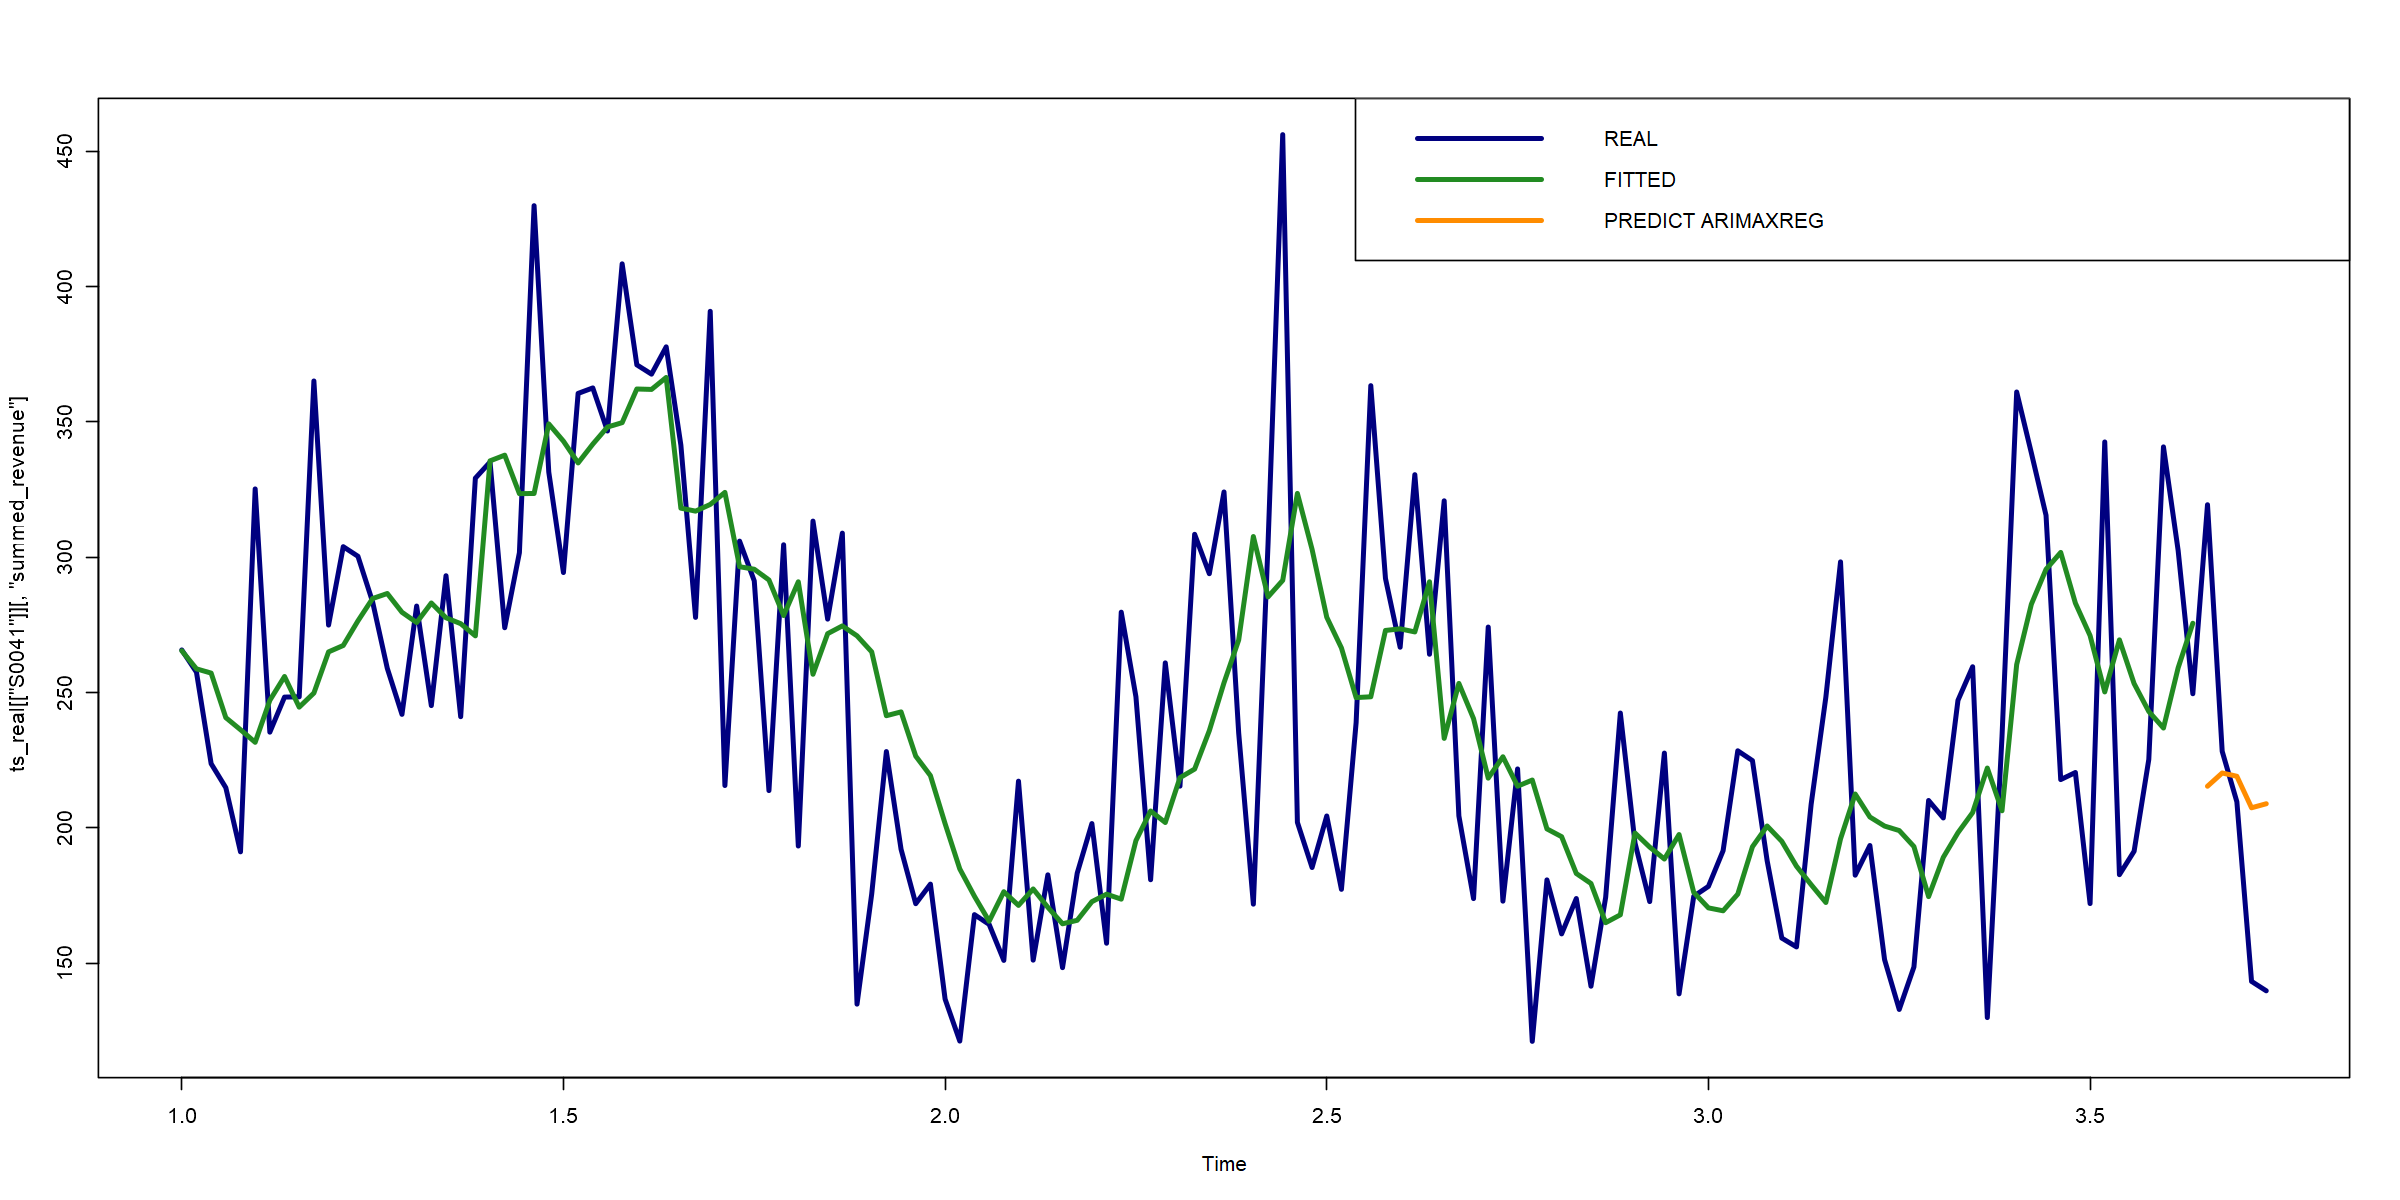

In [35]:
# Ver previsões ex: loja S0041
options(repr.plot.width = 20, repr.plot.height = 10)
predict_arima_xreg <- forecast_values[['S0041']]
# Plot das previsões
plot(ts_real[['S0041']][,"summed_revenue"], col = "navyblue", lwd = 3)
# Adicionar fitted
lines(arima_xreg[['S0041']]$fitted, col = "forestgreen", lwd = 3)
# Adicionar as previsões dos modelos arimaXreg
lines(predict_arima_xreg, col = "darkorange", lwd = 3)
# Adicionar rótulos e legendas ao gráfico
legend("topright", legend = c("REAL","FITTED","PREDICT ARIMAXREG"), col = c("navyblue", "forestgreen", "darkorange"), lwd = 3)

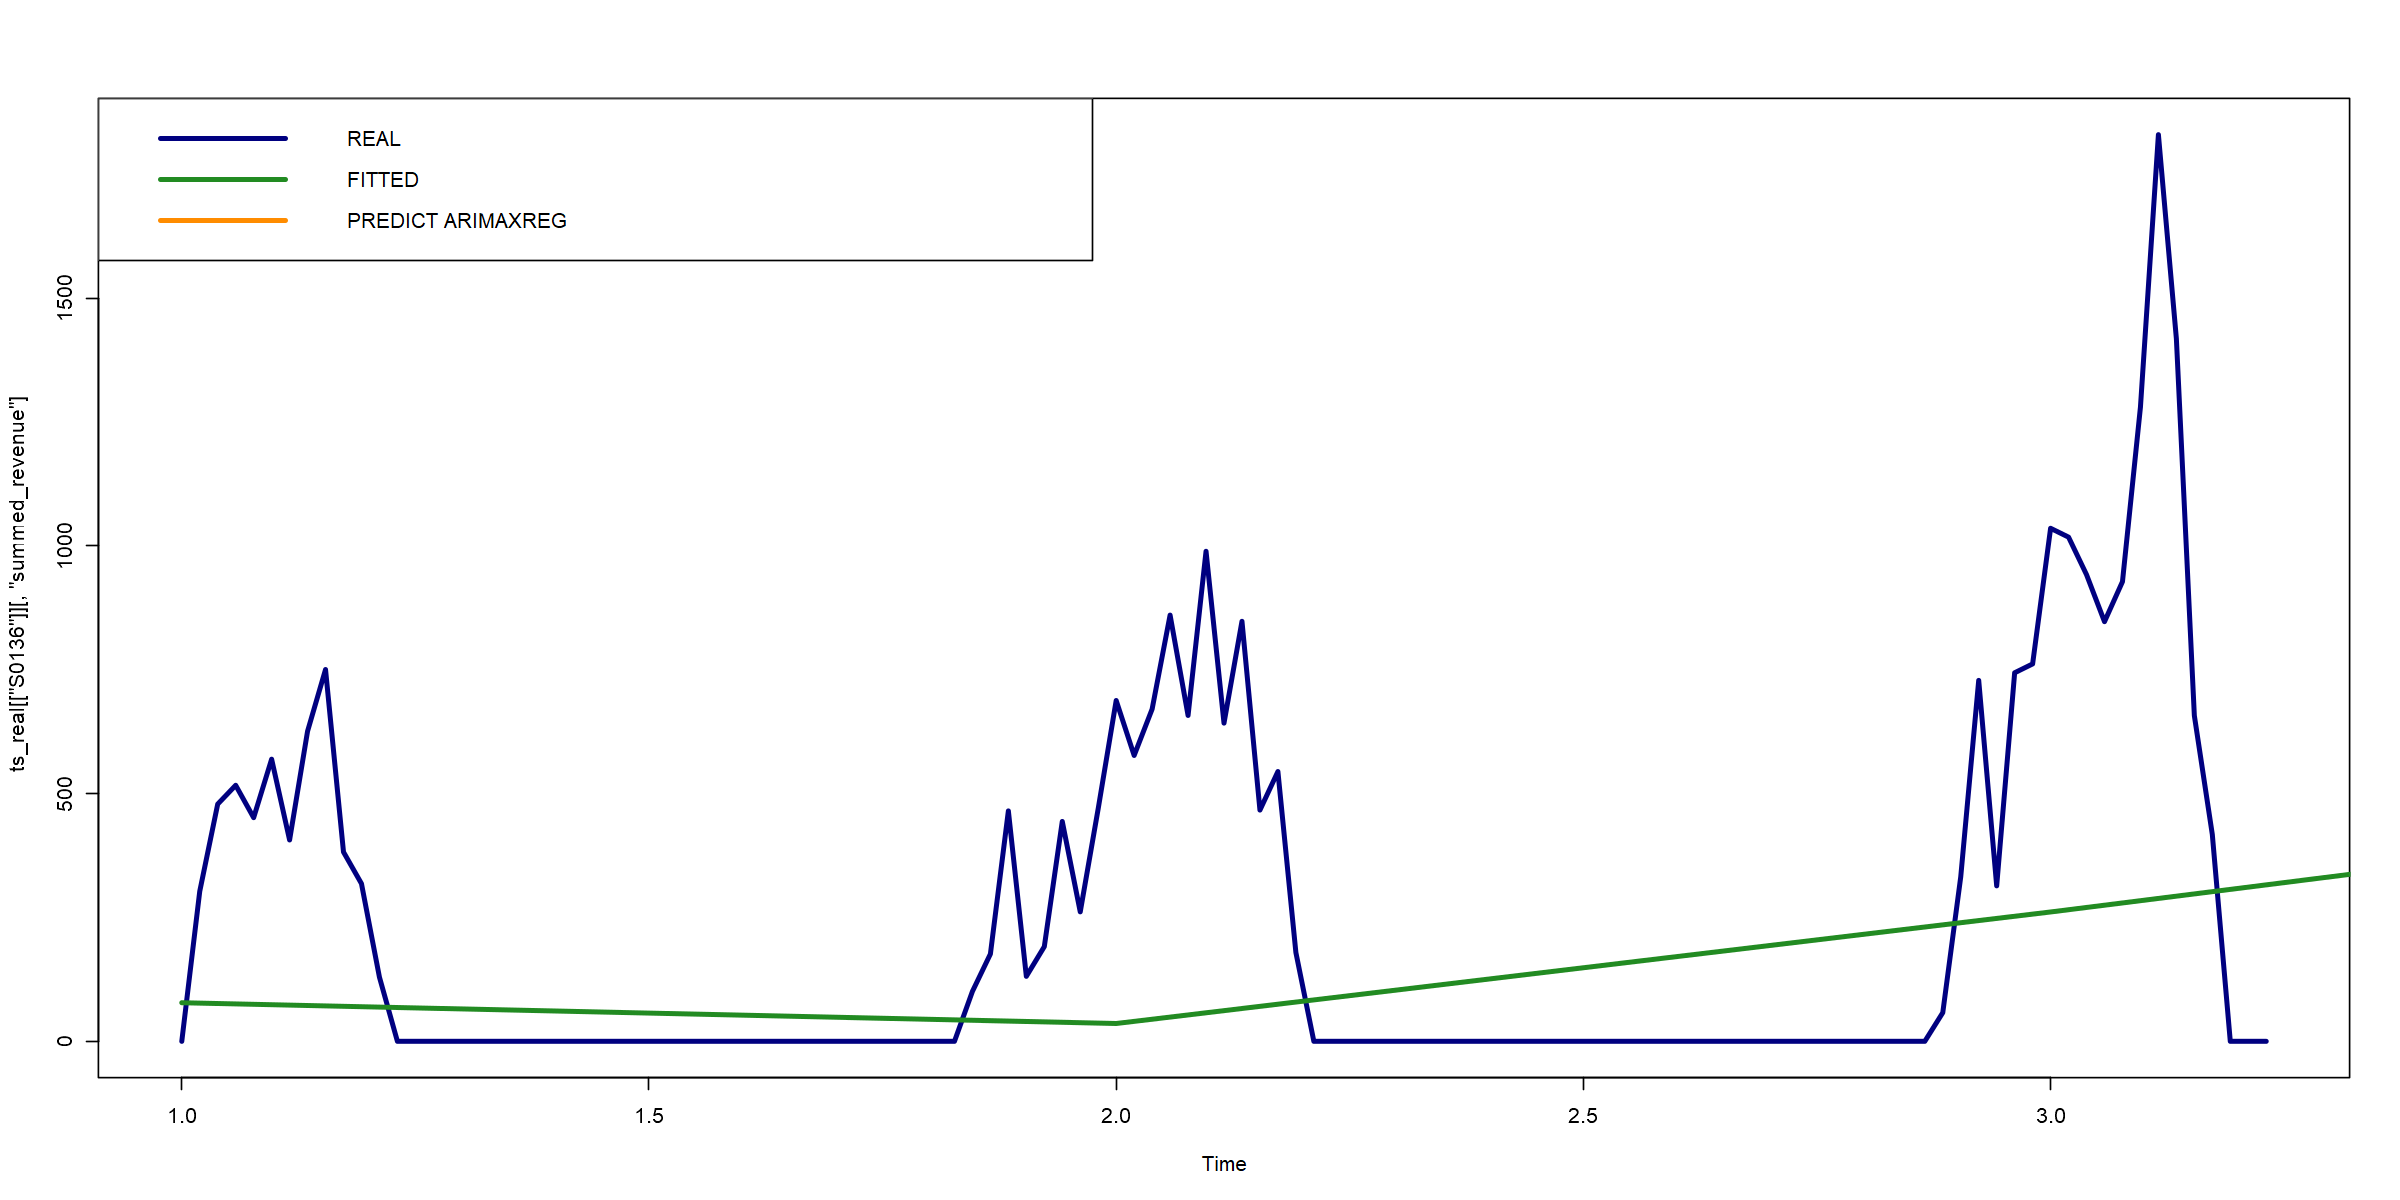

In [36]:
# Ver previsões ex: loja S0136
options(repr.plot.width = 20, repr.plot.height = 10)
predict_arima_xreg <- forecast_values[['S0136']]
# Plot das previsões
plot(ts_real[['S0136']][,"summed_revenue"], col = "navyblue", lwd = 3)
# Adicionar fitted
lines(arima_xreg[['S0136']]$fitted, col = "forestgreen", lwd = 3)
# Adicionar as previsões dos modelos arimaXreg
lines(predict_arima_xreg, col = "darkorange", lwd = 3)
# Adicionar rótulos e legendas ao gráfico
legend("topleft", legend = c("REAL","FITTED","PREDICT ARIMAXREG"), col = c("navyblue", "forestgreen", "darkorange"), lwd = 3)

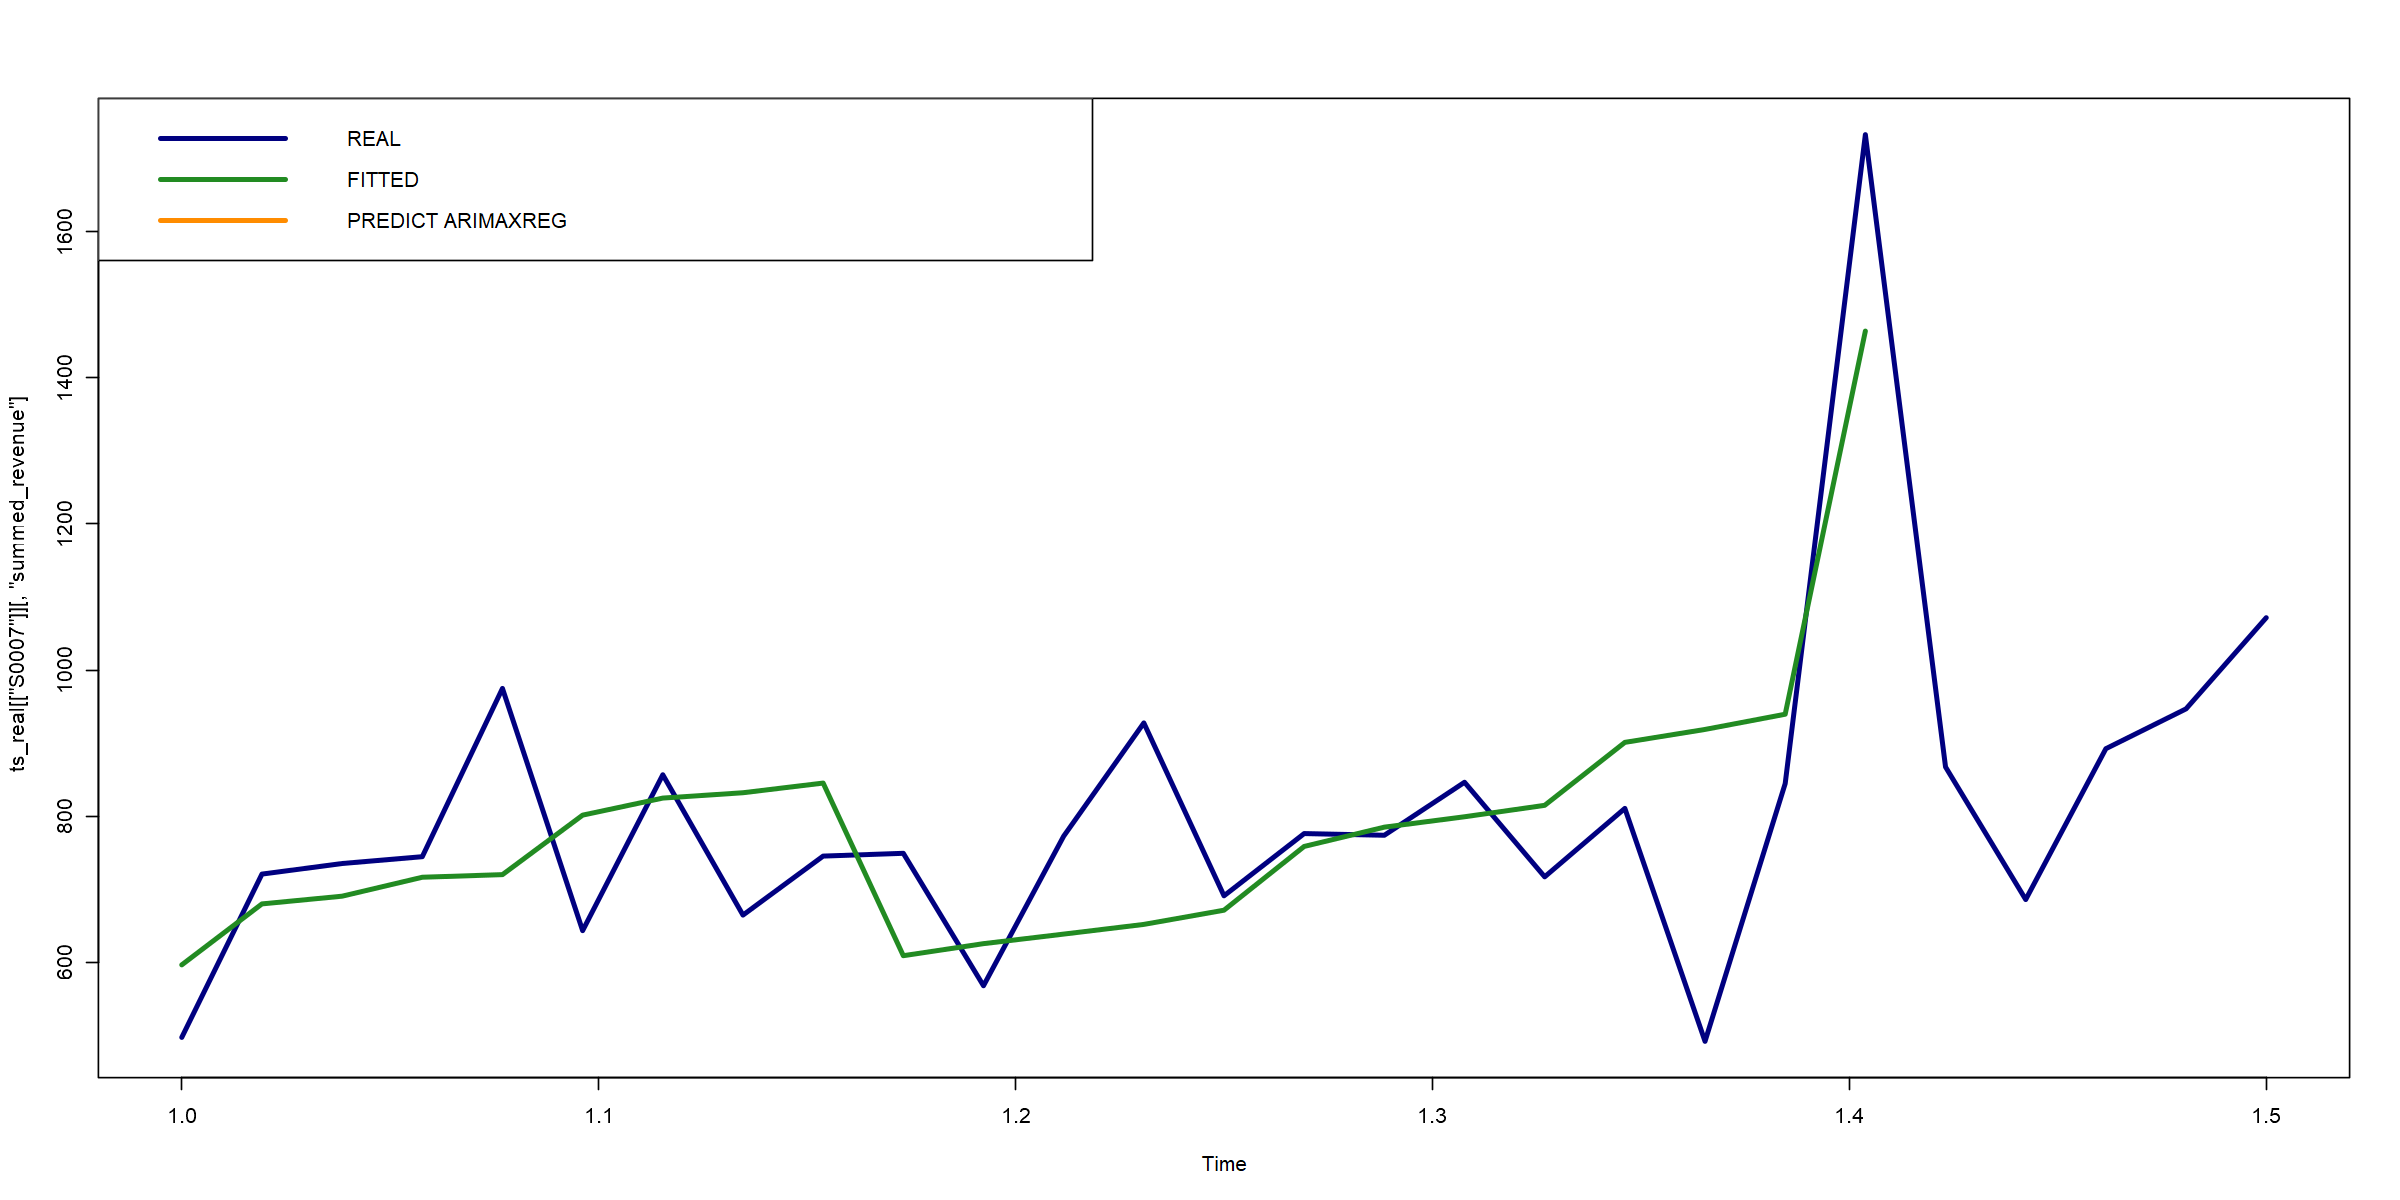

In [37]:
# Ver previsões ex: loja S0007
options(repr.plot.width = 20, repr.plot.height = 10)
predict_arima_xreg <- forecast_values[['S0007']]
# Plot das previsões
plot(ts_real[['S0007']][,"summed_revenue"], col = "navyblue", lwd = 3)
# Adicionar fitted
lines(arima_xreg[['S0007']]$fitted, col = "forestgreen", lwd = 3)
# Adicionar as previsões dos modelos arimaXreg
lines(predict_arima_xreg, col = "darkorange", lwd = 3)
# Adicionar rótulos e legendas ao gráfico
legend("topleft", legend = c("REAL","FITTED","PREDICT ARIMAXREG"), col = c("navyblue", "forestgreen", "darkorange"), lwd = 3)

## Predictions

In [38]:
#criar dataframe com resultados reais
prev <- do.call(rbind, df_test)
prev <- prev[, c('store_id', 'date','summed_revenue')]
# criar dataframe com os resultados arimaXreg
result <- do.call(rbind, forecast_values)
store_id <-names(forecast_values)
# Combinação do índice com a matriz
result_arima_xreg <- data.frame(store_id = store_id, result)
result_arima_xreg <- result_arima_xreg %>% pivot_longer(cols = -store_id, names_to = "prev", values_to = "arima_xreg_revenue")
# juntar resultados num dataframe prev
prev$result_arima_xreg <- result_arima_xreg$arima_xreg_revenue
head(prev,20)

,store_id,date,summed_revenue,result_arima_xreg
,<chr>,<date>,<dbl>,<dbl>
S0002.139,S0002,2019-09-01,4164.56,10037.13
S0002.140,S0002,2019-09-08,6267.91,8449.57
S0002.141,S0002,2019-09-15,5007.57,8295.18
S0002.142,S0002,2019-09-22,3074.56,5907.22
S0002.143,S0002,2019-09-29,5728.25,6113.20
S0003.282,S0003,2019-09-01,1030.02,2228.83
S0003.283,S0003,2019-09-08,1302.61,2826.29
S0003.284,S0003,2019-09-15,1255.40,2821.74
S0003.285,S0003,2019-09-22,1343.15,2208.36


## Evaluation


In [39]:
# Criar uma lista para armazenar as métricas de acurácia
accuracy_list <- list()
# Calcular a acurácia para cada série temporal
for (ts in names(forecast_values)) {
      # Obter os valores reais
      real_values <- as.vector(coredata(ts_test[[ts]]))
      # Obter as previsões
      predicts <- as.vector(coredata(forecast_values[[ts]]))
      # Calcular a acurácia
      accuracy <- accuracy(real_values, predicts)
      # Armazenar as métricas de acurácia na lista
      accuracy_list[[ts]] <- accuracy
}
# Converter a lista de acurácia em um DataFrame
df_accuracy <- do.call(rbind, accuracy_list)
# Adicionar coluna "store_id" com os valores de ts
df_accuracy <- cbind(store_id = names(forecast_values), df_accuracy)
df_accuracy <- as.data.frame(df_accuracy, row.names = NULL)
# Adicionar sufixo "_arimaxreg" às colunas
colnames(df_accuracy)[-1] <- paste(colnames(df_accuracy)[-1], "_arimaxreg", sep = "")
# Ver dataframe
head(df_accuracy)

,store_id,ME_arimaxreg,RMSE_arimaxreg,MAE_arimaxreg,MPE_arimaxreg,MAPE_arimaxreg
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Test.set,S0002,2911.89,3412.5429653178,2911.89,35.6421086383845,35.6421086383845
Test.set.1,S0003,1229.468,1260.74584180952,1229.468,49.4702551280488,49.4702551280488
Test.set.2,S0005,1955.814,2332.04937999606,1955.814,55.6765855262343,55.6765855262343
Test.set.3,S0007,1370.37,1410.50333687659,1370.37,59.7654995053451,59.7654995053451
Test.set.4,S0010,3901.782,3937.98231742856,3901.782,57.4182752976216,57.4182752976216
Test.set.5,S0012,864.938,970.611199801445,864.938,31.6765258867984,31.6765258867984


In [40]:
# Exportar resultados
# Accuracy dataframe
path <- file.path("C:", "Users", "Egomes", "Desktop", "PG_Analytics_Data_science_empresarial", "Isla_gaia", "14-ProjetoII", "projetoII", "dataStaging", "accuracyArimaXregModels.csv")
write.csv(df_accuracy, file = path, row.names = FALSE)
# Resultado previsões em dados teste
path <- file.path("C:", "Users", "Egomes", "Desktop", "PG_Analytics_Data_science_empresarial", "Isla_gaia", "14-ProjetoII", "projetoII", "dataStaging", "resultArimaXregModels.csv")
write.csv(prev, file = path, row.names = FALSE)
print('Exportação concluida!')

[1] "Exportação concluida!"
